# **Aplicaciones en Tecnologías del Lenguaje - Práctica Temas 1 y 2**
## Notebook 1 - Data analysis, exploration and pre-processing
### Student: Alvarez Lacasa, Lucas Alfredo

In this first notebook, I will focus on data analysis, exploration and text representation.
More specifically, I will be dedicated to tasks such as:

- **Initial exploratory data analysis**, which includes simple data visualizations, text analysis, class balance levels, identified issues, potential solutions, etc.
- **Text cleaning and preprocessing**, using techniques for text normalization that facilitate its subsequent processing by any machine learning system.
- **Text representation**, where I will evaluate the use of some techniques to represent text in vector spaces (one-hot vectors, weighting schemes, embeddings, etc.).

To be efficient, I will be documenting in this notebook the output of different versions of the dataset, which I will use to train the models presented in later notebooks. We will identify each dataset version with a version suffix, as we have done in previous exercises, and at the end of this notebook, we will include a table summarizing all the generated versions along with a description of the processing applied to each one. For example, v1 will correspond to the first version, v2 to the second, and so on.

⚠️ As previously mentioned in the [README](../../README.md) file, for this challenge, we will focus on `subtask1`, which is Machine Generated Text Detection.

# Imports globales

Imports are declared in this first section of the notebook.

In [ ]:
import os
import re
import string
from collections import Counter
from collections import defaultdict
from dataclasses import dataclass, field
from enum import StrEnum
from typing import cast

import matplotlib.pyplot as plt
import math
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import stopwordsiso
import unicodedata
from bs4 import BeautifulSoup
from datasets import load_dataset, Dataset
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from sklearn.model_selection import train_test_split
from spacy import Language

nltk.download('punkt')
nltk.download('stopwords')

# Functions and Auxiliary classes

I will define a set of utility functions and classes to avoid code duplication, making the notebook more maintainable and easier to re-execute. I believe this is generally a good practice, especially in longer notebooks, to isolate code execution in a way that reduces the likelihood of errors.

The vast majority of utility functions and classes (regardless of which section of the index they belong to) will be listed here for the sake of simplicity and to make it easier to reload the notebook during development.

In [2]:
"""
=========================
Route resolution class

EDIT THIS CLASS depending on where you will be running this notebook!
=========================
"""

COLAB_BASE_MOUNT_POINT: str = "/content/drive"


@dataclass
class RouteConfig:
    notebook_name: str
    run_in_colab: bool = False
    # TODO: Change this to your base Colab path!!! =========>
    colab_base_mount_point: str = COLAB_BASE_MOUNT_POINT
    colab_practice_base_dir: str = f"{COLAB_BASE_MOUNT_POINT}/My Drive/UNED/master_nlp/AplicacionesNLP/Tema_2/challenge"
    # local_practice_base_dir: str = "/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge"
    local_practice_base_dir: str = "/tmp/pycharm_project_341/Tema_2/challenge"
    # ======================================================>
    exp_output_rel_folder_path: str = "experiment_output"


class RouteResolver:
    """ This object abstracts the retrieval of the files used in this notebook by only editing the RouteConfig class received """

    def __init__(self, route_config: RouteConfig) -> None:
        if route_config.run_in_colab:
            # Import and mount into the base mount path for Google Colab
            from google.colab import drive
            drive.mount(route_config.colab_base_mount_point)

        self._config: RouteConfig = route_config

        # Create experiment output folder for this notebook
        exp_output_notebook_folder: str = self.current_exp_output_folder()
        if not os.path.isdir(exp_output_notebook_folder):
            print(f"Experiment output folder for this notebook does not exist. Creating...")
            os.mkdir(exp_output_notebook_folder)

    def base_folder_path(self) -> str:
        """Returns the base path depending if you're running in Colab or not"""
        return self._config.colab_practice_base_dir if self._config.run_in_colab else self._config.local_practice_base_dir

    def get_exp_output_folder(self) -> str:
        """Returns the path to the experiment outputs folder"""
        return os.path.join(self.base_folder_path(), self._config.exp_output_rel_folder_path)

    def get_exp_output_notebook_folder(self, flow_number: int) -> str:
        """Given flow number if returns the experiment output folder for it"""
        notebook_idx_2_name: dict[int, str] = {
            1: "1_data_exploration",
            2: "2_ml_baselines",
            3: "3_dl_approaches",
            4: "4_results_and_conclusions",
        }
        notebook_name: str = notebook_idx_2_name[flow_number]
        exp_output_notebook_folder: str = os.path.join(self.get_exp_output_folder(), notebook_name)
        validate_condition(condition=os.path.isdir(exp_output_notebook_folder),
                           msg=f"Can't find experiment output for flow: {notebook_name}")
        return exp_output_notebook_folder

    def current_exp_output_folder(self) -> str:
        """Returns experiment output folder for current notebook being ran"""
        return os.path.join(self.get_exp_output_folder(), self._config.notebook_name)

    def dump_registered_paths(self) -> None:
        running_env: str = "COLAB" if self._config.run_in_colab else "LOCAL"
        print("Registered application paths ========")
        print(f"Running environment: {running_env}")
        print(f"Experiment output for this notebook is located in: {self.current_exp_output_folder()}")

In [3]:
"""
=========================================
General utility functions
=========================================
"""


def validate_condition(condition: bool, msg: str, exc_type: type[Exception] = ValueError) -> None:
    """
    If condition is not met, it will raise a ValueError with the arguments provided
    :param condition: condition to validate
    :param msg: string to display in the error
    :param exc_type: type of exception we want to raise. ValueError by default
    :return: ValueError in case condition is not met, None otherwise
    """
    if not condition:
        raise exc_type(msg)


def create_dir_if_not_exists(folder: str) -> None:
    # Create a directory if it does not exist already
    if not os.path.isdir(folder):
        os.mkdir(folder)

In [4]:
"""
=========================
Functions for datasets
=========================
"""


def load_mgt_detection_dataset_as_dataframe() -> tuple[pd.DataFrame, pd.DataFrame]:
    # Load the detection (subtask1) dataset
    detection_dataset: Dataset = load_dataset(path="Genaios/iberautextification",
                                              # Focus on the detection data, we will ignore "model attribution" task
                                              name="detection",
                                              trust_remote_code=True)

    return detection_dataset["train"].to_pandas(), detection_dataset["test"].to_pandas()


def get_more_common_tokens_by_class(df: pd.DataFrame,
                                    tokenizer=WhitespaceTokenizer(),
                                    text_column_name: str = "text",
                                    label_column_name: str = "label",
                                    top_more_popular_tokens: int = 25) -> dict[str, pd.DataFrame]:
    """
    Retrieves a dictionary mapping each class to a pandas DataFrame that contains
    the distribution of the top_k most popular tokens in that class.
    """
    # Use only the relevant columns
    df = df[[text_column_name, label_column_name]]

    # Group by the label and concatenate texts for each class using a fast join operation
    grouped = df.groupby(label_column_name)[text_column_name].agg(" ".join)

    result: dict[str, pd.DataFrame] = {}

    # Process each group: lower-case, tokenize, count tokens, then keep the most common tokens
    for label, text in grouped.items():
        proc_text = text.strip().lower()
        tokens = tokenizer.tokenize(proc_text)
        token_counts = Counter(tokens)
        top_tokens = token_counts.most_common(top_more_popular_tokens)

        # Convert to DataFrame with "token" and "count" columns
        result[label] = pd.DataFrame(top_tokens, columns=["token", "count"])

    return result


def is_ascii(input_value: str) -> bool:
    """ Determines if a given string contains all ascii characters or not """
    return input_value.isascii()


def contains_digits(input_value: str) -> bool:
    """ Determines if a string contains digits or not """
    pattern = r'[0-9]'
    return True if re.findall(pattern, input_value) else False


def contains_url(input_value: str) -> bool:
    """Determines if there is at least one URL in a string"""
    return len(find_urls(input_value)) > 0


url_pattern = re.compile(
    r'http[s]?://'  # http:// or https://
    r'(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|'  # domain...
    r'(?:%[0-9a-fA-F][0-9a-fA-F]))+'  # ...and/or port
    r'(?:/[a-zA-Z0-9$-_@.&+!*\\(\\),%]*)*'  # path
)


def find_urls(text: str) -> list[str]:
    """Find all URLS present in a string"""
    return url_pattern.findall(text)


def does_not_contain_digits(input_value: str) -> bool:
    return not contains_digits(input_value)


def extract_html_tags(html_str: str) -> list[str]:
    soup: BeautifulSoup = BeautifulSoup(html_str, 'html.parser')
    return [str(tag) for tag in soup.find_all()]


def contains_html_tags(input_value: str) -> bool:
    return True if len(extract_html_tags(input_value)) > 0 else False


def extract_non_valid_characters_from_df(df: pd.DataFrame, column_name: str = "text",
                                         validation_function=is_ascii) -> \
        list[list[str]]:
    """ Loops over the given column and proceeds to apply a validation function to each character. If it does not pass it, it includes it as the result """
    non_valid_chars_list: list[list[str]] = []

    # Iterate through each row in the DataFrame
    for _index, row in df.iterrows():
        column: str = row[column_name]
        weird_chars: list[str] = []

        # Iterate through each character in the given column
        for char in column:
            if not validation_function(char):
                weird_chars.append(char)

        # Append the set of weird characters to the list
        non_valid_chars_list.append(weird_chars)

    return non_valid_chars_list


def detect_column_duplicates(df: pd.DataFrame, column_name: str = "text", set: str = "training",
                             label_field: str = "label") -> pd.DataFrame:
    """ Detects the duplicates of a given certain column. Returns the dataframe with this information in case it wants to be used outside """
    all_duplicates: pd.DataFrame = df[df.duplicated(subset=column_name, keep=False)][[column_name, label_field]]
    grouped_df: pd.DataFrame = all_duplicates.groupby(column_name).agg(count=(column_name, 'size'), labels=(
        label_field, lambda x: list(x))).reset_index()

    print(f"Total unique '{column_name}' with the same content for {set} set: {len(grouped_df)}")
    print(f"Total '{column_name}' with the same content for {set} set: {sum(grouped_df['count'])}")

    return grouped_df


def extract_html_tags_from_df(df: pd.DataFrame, column_name: str = "text") -> list[list[str]]:
    """ Loops over a given column and proceeds to extract html tags from it """
    html_tags: list[list[str]] = []

    for _index, row in df.iterrows():
        column: str = row[column_name]
        html_tags.append(extract_html_tags(column))

    return html_tags

In [5]:
"""
===========================
Visualization functions
===========================
"""


def draw_barplot(x: any, y: any, title: str, x_label: str, y_label: str = "Count",
                 figsize: tuple[int, int] = (7, 5), **kwargs) -> None:
    """ Utility function to plot a bar plot given data """
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=x, y=y)
    # Set counts on each token on top of bar plot
    for i in ax.containers:
        ax.bar_label(i, )
    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    plt.show()


def draw_pie_chart(counts: list[int], labels: list[str], title: str, figsize=(7, 7), **kwargs) -> None:
    """ Utility function to plot a pie chart """
    # define Seaborn color palette to use
    colors = sns.color_palette('pastel')[0:5]
    plt.title(title)
    plt.pie(counts, labels=labels, colors=colors, autopct='%.0f%%')
    fig = plt.gcf()
    fig.set_size_inches(figsize)
    plt.show()


def draw_histogram(data: pd.DataFrame, title: str, x_label: str, y_label: str = "Count", log_scale: bool = False,
                   figsize: tuple[int, int] = (7, 5), **kwargs) -> None:
    """ Utility function to plot a histogram from data. """
    f, ax = plt.subplots(figsize=figsize)
    sns.histplot(
        data,
        #palette="light:m_r",
        edgecolor=".6",
        linewidth=.5,
        log_scale=log_scale,
        kde=True,
        **kwargs
    )
    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    plt.show()


def plot_multiple_charts(plot_functions, titles=None, n_cols=2, figsize=(12, 6)):
    """
    Plots multiple charts in a grid layout.

    Parameters:
    - plot_functions: List of functions that take an Axes object and plot directly on it.
    - titles: List of titles for each subplot.
    - n_cols: Number of columns in the grid.
    - figsize: Tuple defining the size of the entire figure.
    """
    n_plots = len(plot_functions)
    n_rows = (n_plots + n_cols - 1) // n_cols  # Calculate rows needed based on number of plots

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten in case of multi-dimensional axes for easier iteration

    for i, plot_func in enumerate(plot_functions):
        plot_func(axes[i])  # Call each plot function with its respective Axes
        if titles and i < len(titles):
            axes[i].set_title(titles[i])

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def plot_stacked_bar_for_domain(df: pd.DataFrame, domain: str, figsize: tuple[int, int] = (10, 6)) -> None:
    """
    Plots a stacked bar chart for a given domain.

    Parameters:
    - df: DataFrame with columns ['id', 'prompt', 'text', 'label', 'domain', 'language', 'model', 'short_model']
    - domain: The domain for which the plot should be generated (string)
    """
    # Filter the DataFrame for the given domain
    domain_df = df[df['domain'] == domain]

    # Group by model and language to count the number of texts
    grouped = domain_df.groupby(['short_model', 'language']).size().unstack(fill_value=0)

    # Plotting
    ax = grouped.plot(kind='bar', stacked=True, figsize=figsize, colormap='tab20')

    # Customizing the plot
    ax.set_title(f"Distribution by 'short_model' and 'language' for '{domain}' domain")
    ax.set_xlabel('short_model')
    ax.set_ylabel('# samples')
    ax.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()

# Route resolution

We will use a `RouteResolver` class to handle the paths, isolating that information so it can be modified in a single place within the notebook.

Check the output of the following cell if you plan to re-run the notebook to ensure the paths are pointing to the correct locations. This time, I used `run_in_colab=False` since I was able to do all the processing on my personal laptop.

Notice that in this case, in order to avoid commiting the files of the train and test sets (they're fairly big), we will read it all from HuggingFace and process it on the fly (memory).

In [6]:
# Routes
route_resolver: RouteResolver = RouteResolver(
    RouteConfig(run_in_colab=False, notebook_name="1_data_exploration"))
route_resolver.dump_registered_paths()

Experiment output folder for this notebook does not exist. Creating...
Registered application paths ========
Running environment: LOCAL
Experiment output for this notebook is located in: /tmp/pycharm_project_341/Tema_2/challenge/experiment_output/1_data_exploration


# Initial data exploration
The idea of this section is to load the data from our dataset and perform an initial exploration to understand the information we have. Things we are interested in determining here include identifying which data we can use to train and which to test our model.

By reading their [official HuggingFace documentation](https://huggingface.co/datasets/Genaios/iberautextification), we can see that there is a train/test split already done. We will have to decide later how to perform the train/val split from our training data.

Since these are *".tsv"* files, HuggingFace datasets have a very useful function that lets us load the dataset as a [Pandas](https://pandas.pydata.org/) Dataframe.

## Loading Datasets

In [8]:
train_df, test_df = load_mgt_detection_dataset_as_dataframe()

In [9]:
train_df.head(3)

,id,prompt,text,label,domain,language,model
0,15442,Write a wikipedia article using the following ...,Es un tribunal de suprema instanza que forma p...,1,wikipedia,ca,cohere.command-text-v14
1,26409,NO-PROMPT,Aixó de tindrer la platgeta tant prou era un p...,0,reviews,ca,human
2,12777,Write a wikipedia article using the following ...,Doug mcadam es un científico estadista estadou...,1,wikipedia,es,cohere.command-text-v14


In [10]:
test_df.head(3)

,id,prompt,text,label,domain,language,model
0,126991,"Respond to the following, in English.\nInput: ...","You""re welcome! i""m glad you think so. is ther...",1,chat,en,meta-llama/Llama-2-70b-chat-hf
1,146484,"Respond to the following, in Catalan.\nInput: ...",¡claro! aquí tienes el llistat especialitzat e...,1,chat,ca,mistralai/Mixtral-8x7B-Instruct-v0.1
2,35684,"Respond to the following, in Catalan.\nInput: ...",El dret al treball és un dret humà fonamental ...,1,chat,ca,mistralai/Mixtral-8x7B-Instruct-v0.1


In [11]:
train_df.columns

Index(['id', 'prompt', 'text', 'label', 'domain', 'language', 'model'], dtype='object')

In [12]:
test_df.columns

Index(['id', 'prompt', 'text', 'label', 'domain', 'language', 'model'], dtype='object')

"model" names are sort of long. Let's add a new column with "short_model" that maps the names to something more friendly.

In [13]:
mappings: dict[str, str] = {
    "cohere.command-text-v14": "cohere-command-text-v14",
    "human": "human",
    "gpt-3.5-turbo-instruct": "gpt-3.5-turbo-instruct",
    "ai21.j2-ultra-v1": "ai21-j2-ultra-v1",
    "gpt-4": "gpt-4",
    "mistralai/Mixtral-8x7B-Instruct-v0.1": "mixtral-8x7B-instruct",
    "meta-llama/Llama-2-70b-chat-hf": "llama-2-70b-chat-hf",
}

train_df["short_model"] = train_df["model"].apply(lambda x: mappings[x])
test_df["short_model"] = test_df["model"].apply(lambda x: mappings[x])

In [14]:
list(train_df["short_model"].unique())

['cohere-command-text-v14',
 'human',
 'gpt-3.5-turbo-instruct',
 'ai21-j2-ultra-v1',
 'gpt-4',
 'mixtral-8x7B-instruct',
 'llama-2-70b-chat-hf']

We can see that the dataset offers the following columns:
- **id**: numeric identifier of each row (sample).
- **prompt**: the prompt that was provided to the LLM in order to generate the answer (`text`).
- **text**: the answer generated by the LLM (or human) for a given `prompt`.
- **label**: if it was human or MGT.
- **domain**: the domain for which the text was generated.
- **language**: the language in which the generated text is.
- **model**: the LLM that was used to generate the text. This information seems useful for the model attribution task. For the MGT detection task, it doesn't seem to be of much utility.
- **short_model**: added by me, only to keep plot charts cleaner.

In [13]:
# Display basic info about both dataframes
print("Train dataframe info ====")
train_df.info()

Train dataframe info ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109663 entries, 0 to 109662
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        109663 non-null  int64 
 1   prompt    109663 non-null  object
 2   text      109663 non-null  object
 3   label     109663 non-null  int64 
 4   domain    109663 non-null  object
 5   language  109663 non-null  object
 6   model     109663 non-null  object
dtypes: int64(2), object(5)
memory usage: 5.9+ MB


In [14]:
print("Train dataframe missing values ====")
train_df.isnull().sum()

Train dataframe missing values ====


id          0
prompt      0
text        0
label       0
domain      0
language    0
model       0
dtype: int64

In [15]:
print("Train dataframe describe info ====")
train_df["label"].describe()

Train dataframe describe info ====


count    109663.000000
mean          0.535769
std           0.498721
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: label, dtype: float64

In [16]:
print("Test dataframe info ====")
test_df.info()

Test dataframe info ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43365 entries, 0 to 43364
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        43365 non-null  int64 
 1   prompt    43365 non-null  object
 2   text      43365 non-null  object
 3   label     43365 non-null  int64 
 4   domain    43365 non-null  object
 5   language  43365 non-null  object
 6   model     43365 non-null  object
dtypes: int64(2), object(5)
memory usage: 2.3+ MB


In [17]:
print("Test dataframe missing values ====")
test_df.isnull().sum()

Test dataframe missing values ====


id          0
prompt      0
text        0
label       0
domain      0
language    0
model       0
dtype: int64

In [18]:
print("Test dataframe describe info ====")
test_df["label"].describe()

Test dataframe describe info ====


count    43365.000000
mean         0.551943
std          0.497300
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64

In [19]:
test_set_perc: float = round((test_df.shape[0] / (train_df.shape[0] + test_df.shape[0])) * 100, 2)
print(f"Total train elements: {len(train_df)}")
print(f"Total test elements: {len(test_df)}")
print(f"Test set represents: {test_set_perc}% of the data")

Total train elements: 109663
Total test elements: 43365
Test set represents: 28.34% of the data


Some relevant findings:
- The dataset has multiple dimensions that make its analysis interesting: "domain", "model" and "language". Notice that from "model" can always derive the "label".
- We have **109663 elements for train** y **43365 for test**.
- The initial data split seems to be 70% train and around ~~30% test.
- There are no null elements in train or test sets.
- Distribution of "human" and "MGT" categories is very similar for train and test.

## Class distribution - Basic Dimensions

We'll start by inspecting class distribution.

### Train Set

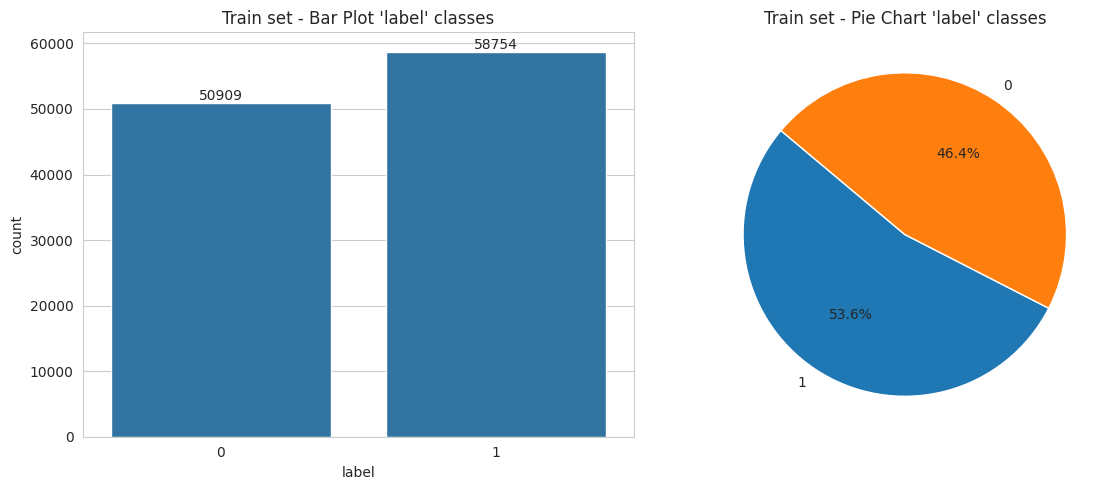

In [38]:
plot_multiple_charts(
    [
        lambda ax: sns.countplot(train_df, x="label", ax=ax).bar_label(ax.containers[0]),

        lambda ax: ax.pie(train_df["label"].value_counts(),
                          labels=train_df["label"].value_counts().index,
                          autopct='%1.1f%%', startangle=140)
    ],
    titles=[
        "Train set - Bar Plot 'label' classes",
        "Train set - Pie Chart 'label' classes"],
    n_cols=2,
    figsize=(12, 5)
)

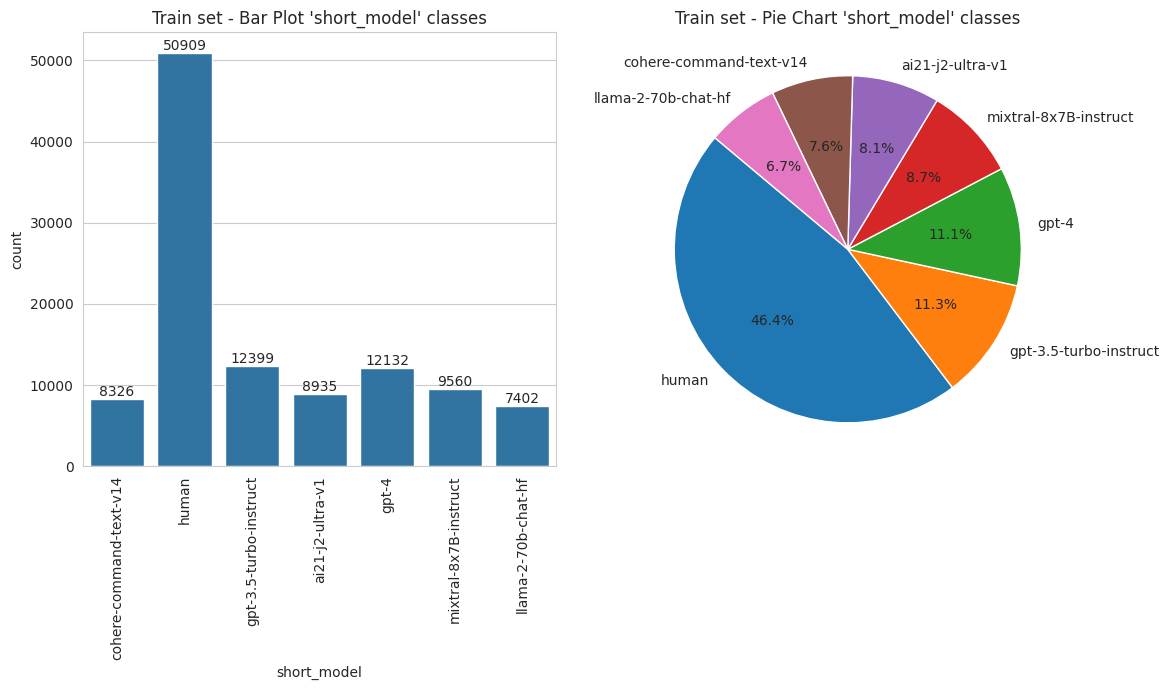

In [72]:
plot_multiple_charts(
    [
        lambda ax: (
            sns.countplot(data=train_df, x="short_model", ax=ax),
            ax.bar_label(ax.containers[0]),
            ax.tick_params(axis='x', rotation=90)
        ),
        lambda ax: ax.pie(train_df["short_model"].value_counts(),
                          labels=train_df["short_model"].value_counts().index,
                          autopct='%1.1f%%', startangle=140)
    ],
    titles=[
        "Train set - Bar Plot 'short_model' classes",
        "Train set - Pie Chart 'short_model' classes"],
    n_cols=2,
    figsize=(12, 7)
)

We can see that "human" is also one of the "model" labels. This also means that:
- label=0 -> human generated text
- label=1 -> MGT

In between the LLMs, we can see that that the train distribution of samples for each of them differs a bit depending on the model (is not homogenous).
Models like `gpt-3.5-turbo-instruct` or `gtp-4` have considerably more number of samples that the rest. I have no idea why this is the case.

### Test Set

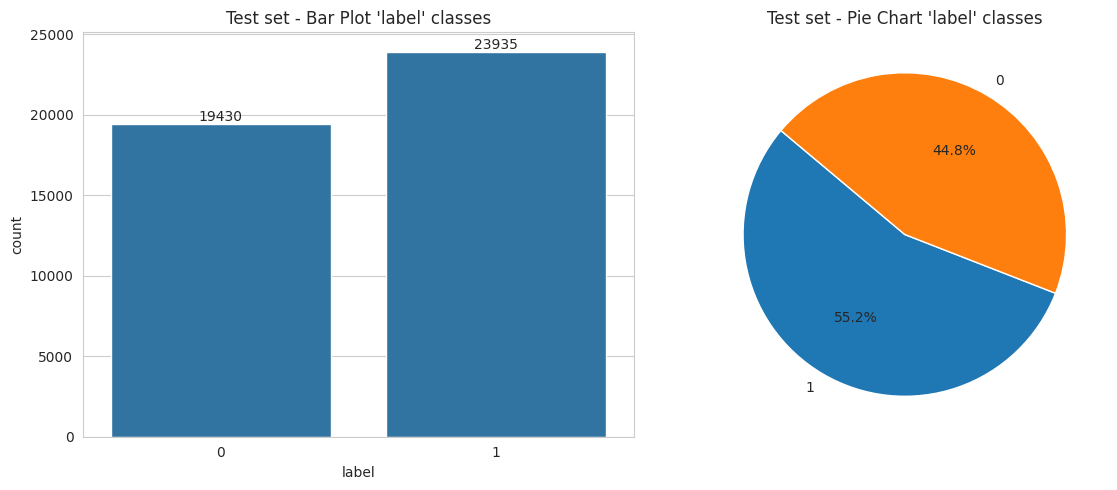

In [39]:
plot_multiple_charts(
    [
        lambda ax: sns.countplot(test_df, x="label", ax=ax).bar_label(ax.containers[0]),

        lambda ax: ax.pie(test_df["label"].value_counts(),
                          labels=test_df["label"].value_counts().index,
                          autopct='%1.1f%%', startangle=140)
    ],
    titles=[
        "Test set - Bar Plot 'label' classes",
        "Test set - Pie Chart 'label' classes"],
    n_cols=2,
    figsize=(12, 5)
)

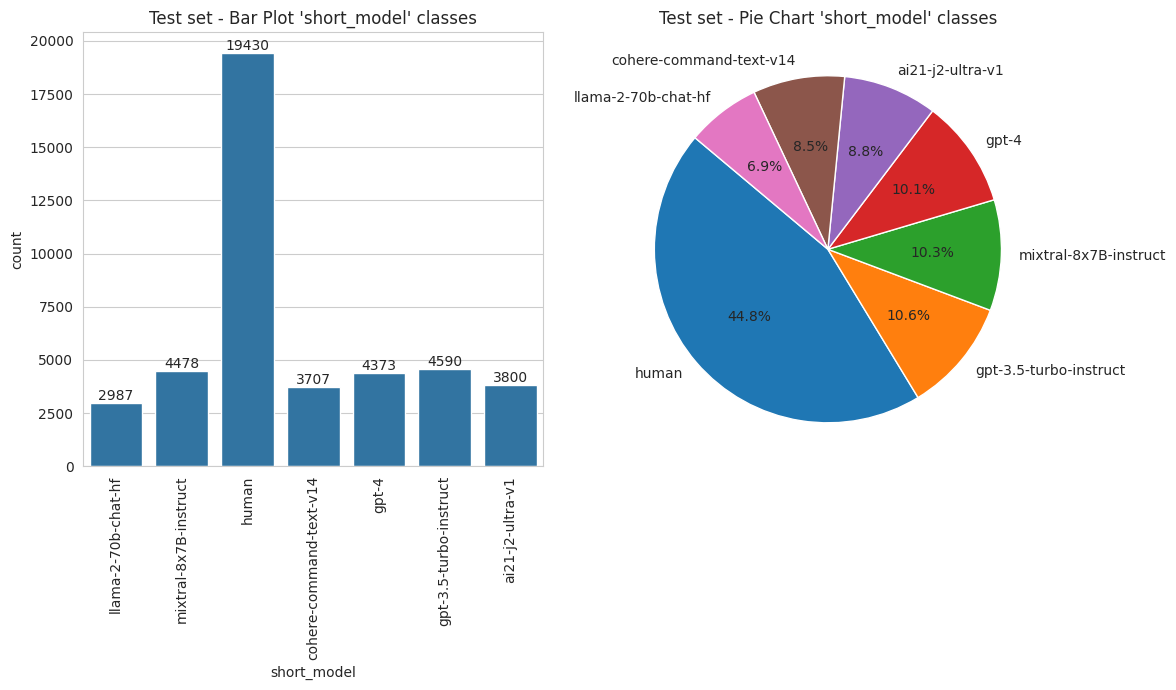

In [73]:
plot_multiple_charts(
    [
        lambda ax: (
            sns.countplot(data=test_df, x="short_model", ax=ax),
            ax.bar_label(ax.containers[0]),
            ax.tick_params(axis='x', rotation=90)
        ),
        lambda ax: ax.pie(test_df["short_model"].value_counts(),
                          labels=test_df["short_model"].value_counts().index,
                          autopct='%1.1f%%', startangle=140)
    ],
    titles=[
        "Test set - Bar Plot 'short_model' classes",
        "Test set - Pie Chart 'short_model' classes"],
    n_cols=2,
    figsize=(12, 7)
)

In [89]:
train_df[train_df["label"] == 0]["prompt"].value_counts()

prompt
NO-PROMPT    50909
Name: count, dtype: int64

In [90]:
test_df[test_df["label"] == 0]["prompt"].value_counts()

prompt
NO-PROMPT    19430
Name: count, dtype: int64

We note similar characteristics than the ones observed for the train set. However, I'm not sure the train/test sets have been created via a stratified split, as the proportion of samples that we have for each model is not preserved here. We can observe how the `mistralai/Mixtral-8x7B-Instruct-v0.1` model also appears as one of the more popular models in the test set (this was not the case in the train set).

In any case, since we have to worry about the binary distribution of samples ("human" vs "MGT"), even though is not strictly balanced, **I think it's good enough to proceed**.

Notice that in order to balance the distribution more (now it's around 53.6% to 46.4%, with the MGT class being more represented), we could follow some strategies:
- Remove some samples from the MGT class. Maybe here we can use a general purpose multilingual encoder and try to find texts in the MGT category that are not similar to any of the texts written in the human category, and remove those samples from the MGT category. I'm saying this, because for this binary classification task, it's interesting to have samples answering the same type of question or prompt but written by a human and by an LLM, so that our classifier can learn how to distinguish them.
- Augment the human samples so that the distribution is more even. We can take texts from the MGT class that are not similar to any of the texts in the human class and have human annotators answers for those prompts. Notice that this would involve manual/human evaluation, it cannot be automated.
- 👎 Based on the stats I'm showing before, we can see that for human generated texts, there is no prompt (there is, but with value `NO-PROMPT`). In my opinion, it could've been relevant to include the question that the human writer was generating the answer for, as this could've been use to cluster similar questions/prompts to apply augmentation techniques.

## Class distribution - Additional dimensions

As I previously mentioned, this dataset has multiple dimensions that make it's analysis interesting:
- "domain"
- "model"
- "language"

In this section, we will try to plot some charts in order to get some insights from these additional dimensions as well.

### Train Set

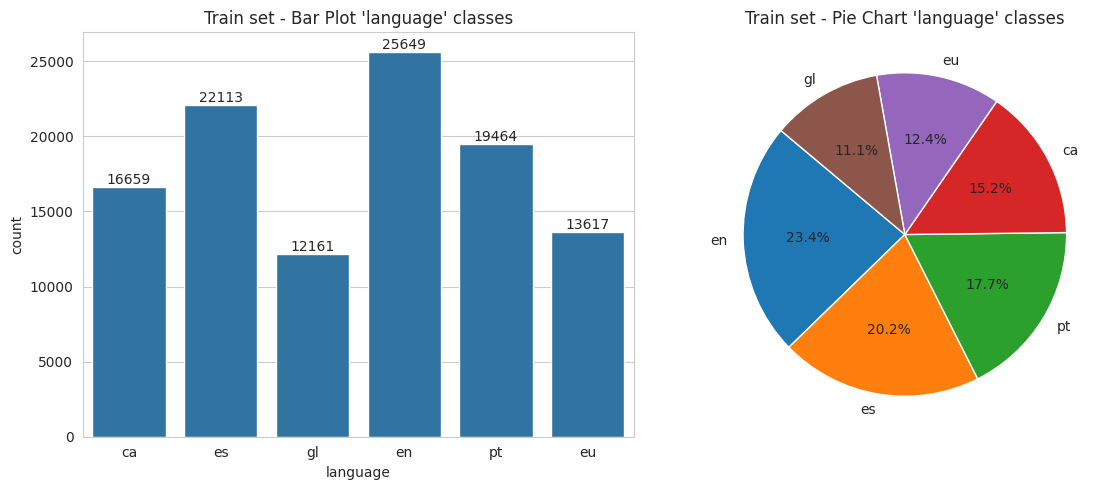

In [42]:
plot_multiple_charts(
    [
        lambda ax: sns.countplot(train_df, x="language", ax=ax).bar_label(ax.containers[0]),

        lambda ax: ax.pie(train_df["language"].value_counts(),
                          labels=train_df["language"].value_counts().index,
                          autopct='%1.1f%%', startangle=140)
    ],
    titles=[
        "Train set - Bar Plot 'language' classes",
        "Train set - Pie Chart 'language' classes"],
    n_cols=2,
    figsize=(12, 5)
)

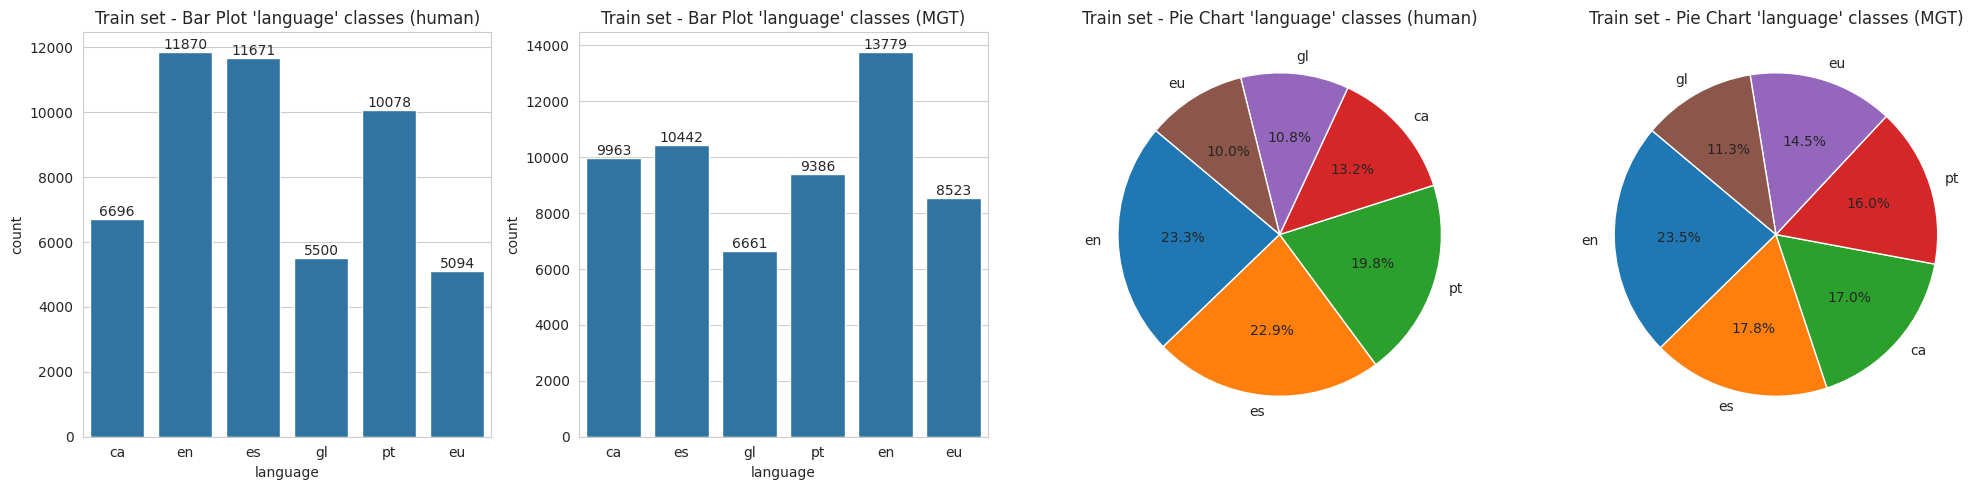

In [37]:
train_df_human: pd.DataFrame = train_df[train_df["label"] == 0]
train_df_mgt: pd.DataFrame = train_df[train_df["label"] == 1]

plot_multiple_charts(
    [
        lambda ax: sns.countplot(train_df_human, x="language", ax=ax).bar_label(ax.containers[0]),
        lambda ax: sns.countplot(train_df_mgt, x="language", ax=ax).bar_label(ax.containers[0]),
        lambda ax: ax.pie(train_df_human["language"].value_counts(),
                          labels=train_df_human["language"].value_counts().index,
                          autopct='%1.1f%%', startangle=140),
        lambda ax: ax.pie(train_df_mgt["language"].value_counts(),
                          labels=train_df_mgt["language"].value_counts().index,
                          autopct='%1.1f%%', startangle=140)

    ],
    titles=[
        "Train set - Bar Plot 'language' classes (human)",
        "Train set - Bar Plot 'language' classes (MGT)",
        "Train set - Pie Chart 'language' classes (human)",
        "Train set - Pie Chart 'language' classes (MGT)",
    ],
    n_cols=4,
    figsize=(20, 5)
)

We observe some variations, but they don't seem to be significant.

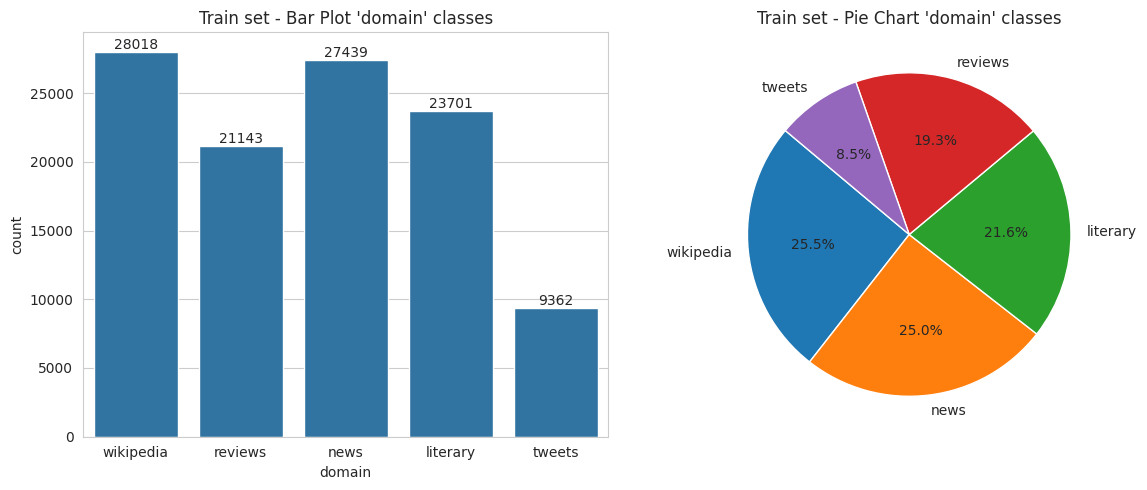

In [45]:
plot_multiple_charts(
    [
        lambda ax: sns.countplot(train_df, x="domain", ax=ax).bar_label(ax.containers[0]),

        lambda ax: ax.pie(train_df["domain"].value_counts(),
                          labels=train_df["domain"].value_counts().index,
                          autopct='%1.1f%%', startangle=140)
    ],
    titles=[
        "Train set - Bar Plot 'domain' classes",
        "Train set - Pie Chart 'domain' classes"],
    n_cols=2,
    figsize=(12, 5)
)

The distribution of domains is also not even. We observe categories such as "tweets" which are underrepresented in the train set.

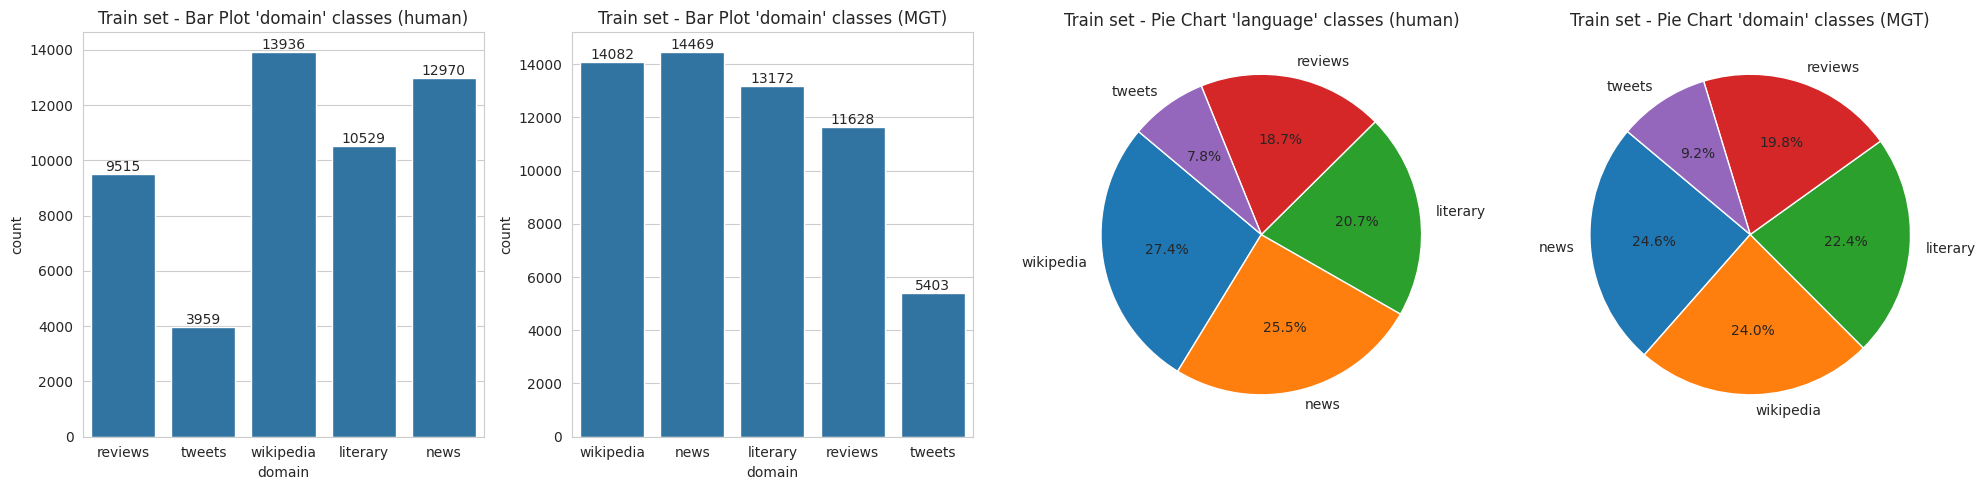

In [46]:
plot_multiple_charts(
    [
        lambda ax: sns.countplot(train_df_human, x="domain", ax=ax).bar_label(ax.containers[0]),
        lambda ax: sns.countplot(train_df_mgt, x="domain", ax=ax).bar_label(ax.containers[0]),
        lambda ax: ax.pie(train_df_human["domain"].value_counts(),
                          labels=train_df_human["domain"].value_counts().index,
                          autopct='%1.1f%%', startangle=140),
        lambda ax: ax.pie(train_df_mgt["domain"].value_counts(),
                          labels=train_df_mgt["domain"].value_counts().index,
                          autopct='%1.1f%%', startangle=140)

    ],
    titles=[
        "Train set - Bar Plot 'domain' classes (human)",
        "Train set - Bar Plot 'domain' classes (MGT)",
        "Train set - Pie Chart 'language' classes (human)",
        "Train set - Pie Chart 'domain' classes (MGT)",
    ],
    n_cols=4,
    figsize=(20, 5)
)

In this case, the distribution of domains is also kind of similar regardless if it's for the "human" or "MGT" label.

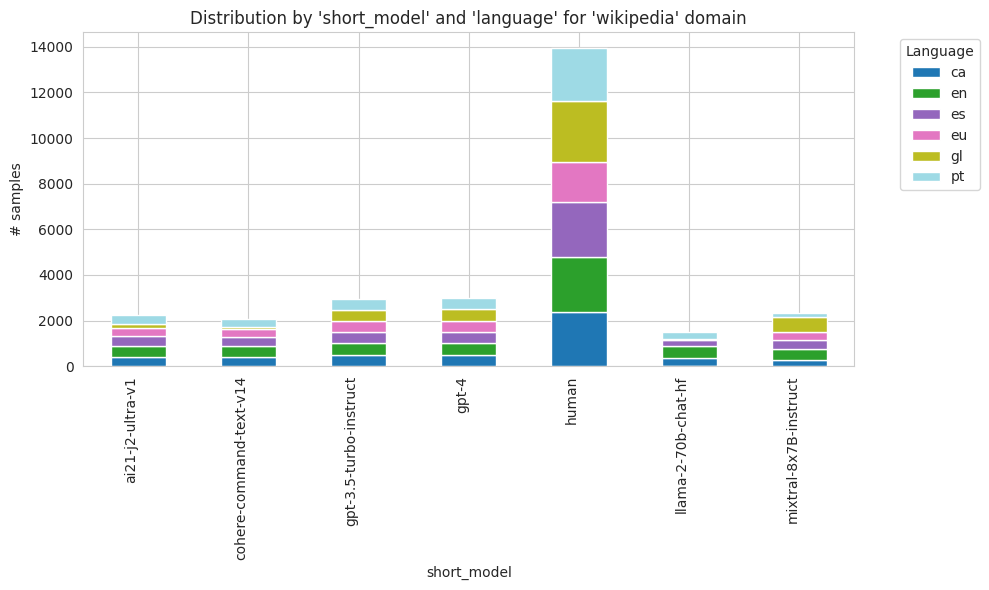

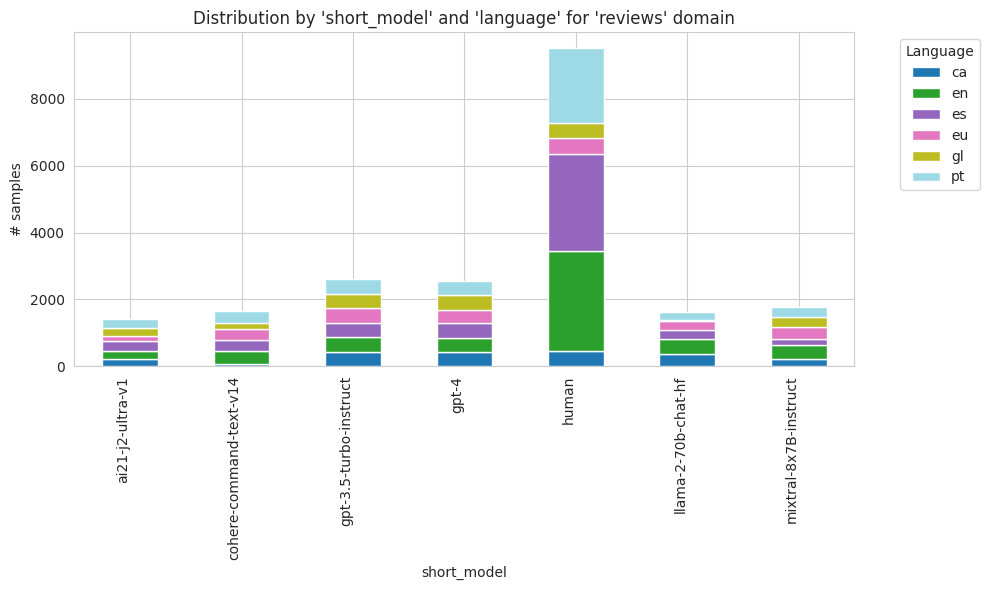

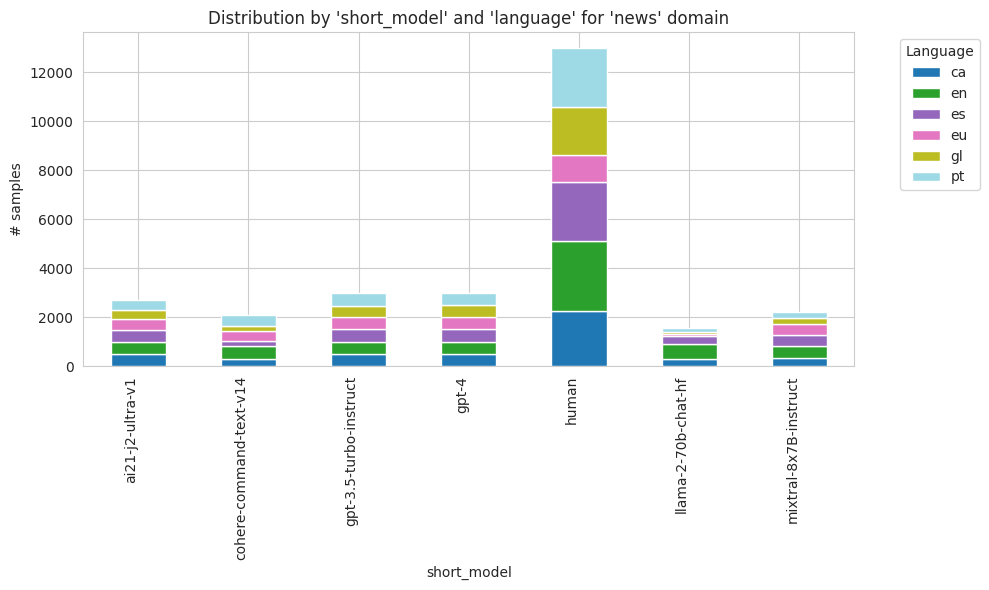

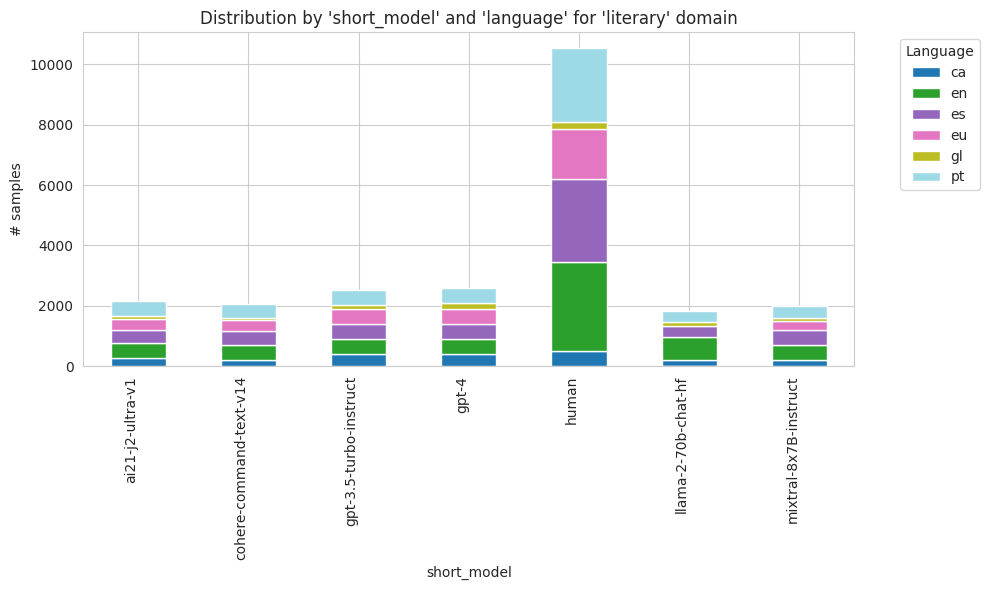

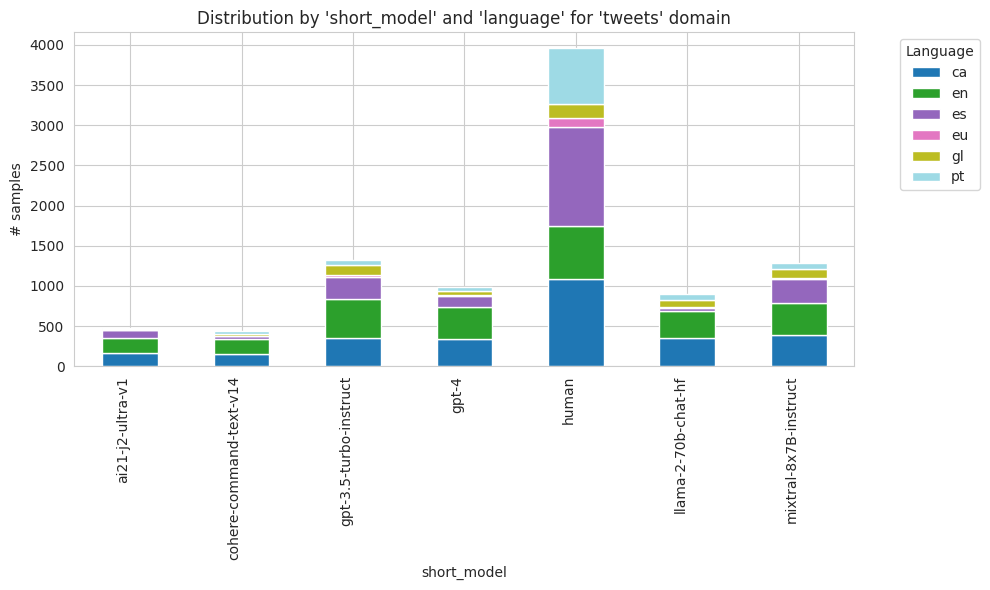

In [80]:
for domain in train_df["domain"].unique():
    plot_stacked_bar_for_domain(train_df, domain=domain)

It's interesting to notice the contribution of each model to the different domains and how they used the LLMs to generate texts in different languages.

In [86]:
list(train_df[(train_df["language"] == "es") & (train_df["label"] == 1)].sample(10)["prompt"])

['Write a book chapter in Spanish that begins with the two given sentences. Do not write the title of the chapter or repeat the two sentences given. Refrain to introduce the chapter with sentences like "Aquí va un capítulo propio que empieza con los dos frases proporcionadas".\\n\\nChapter: y dijo en voz muy baja —Si lo has hecho, entonces, no dudes en forcejear. ',
 'Write a book chapter in Spanish that begins with the two given sentences. Do not write the title of the chapter or repeat the two sentences given. Refrain to introduce the chapter with sentences like "Aquí va un capítulo propio que empieza con los dos frases proporcionadas".\\n\\nChapter: ó la batuta. Tras un momento de silencio estremecedor, una tormenta de música emergió de los instrumentos de viento y cuerda y penetró en el pecho de Andras, llenándole la caja torácica hasta dejarlo casi sin aliento. ',
 'Write a book chapter in Spanish that begins with the two given sentences. Do not write the title of the chapter or r

It's interesting to notice that for languages different than English, they mixed prompts in English (but telling to the model to write in Spanish) and also in Spanish directly.

### Test Set

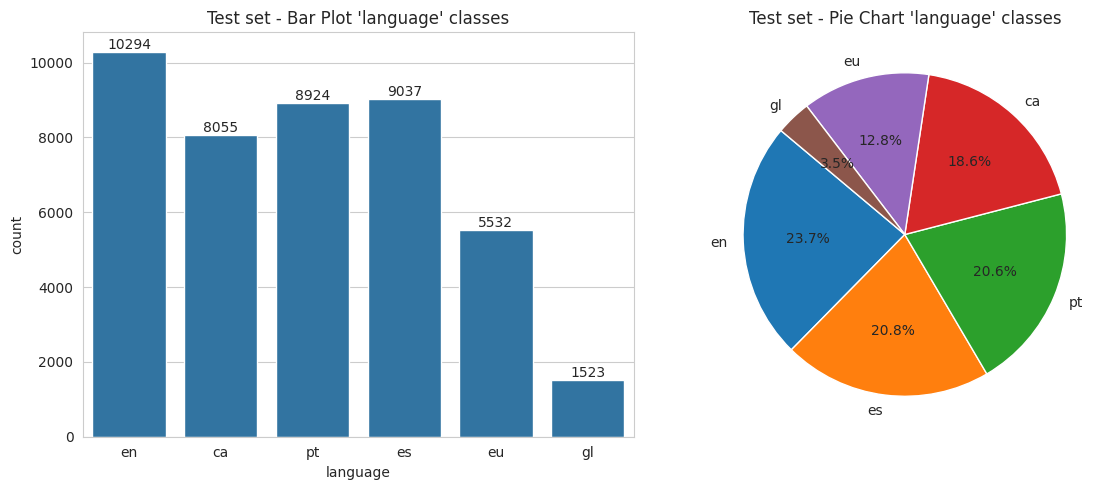

In [44]:
plot_multiple_charts(
    [
        lambda ax: sns.countplot(test_df, x="language", ax=ax).bar_label(ax.containers[0]),

        lambda ax: ax.pie(test_df["language"].value_counts(),
                          labels=test_df["language"].value_counts().index,
                          autopct='%1.1f%%', startangle=140)
    ],
    titles=[
        "Test set - Bar Plot 'language' classes",
        "Test set - Pie Chart 'language' classes"],
    n_cols=2,
    figsize=(12, 5)
)

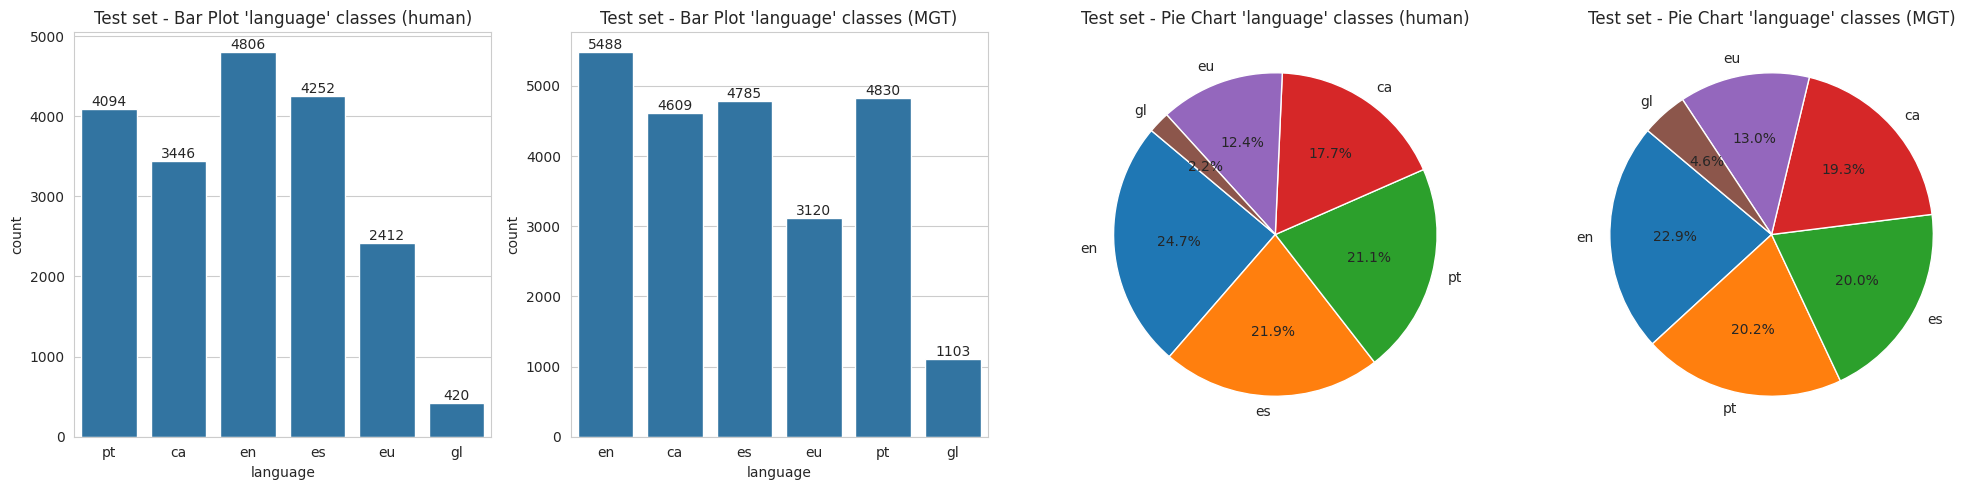

In [91]:
test_df_human: pd.DataFrame = test_df[test_df["label"] == 0]
test_df_mgt: pd.DataFrame = test_df[test_df["label"] == 1]

plot_multiple_charts(
    [
        lambda ax: sns.countplot(test_df_human, x="language", ax=ax).bar_label(ax.containers[0]),
        lambda ax: sns.countplot(test_df_mgt, x="language", ax=ax).bar_label(ax.containers[0]),
        lambda ax: ax.pie(test_df_human["language"].value_counts(),
                          labels=test_df_human["language"].value_counts().index,
                          autopct='%1.1f%%', startangle=140),
        lambda ax: ax.pie(test_df_mgt["language"].value_counts(),
                          labels=test_df_mgt["language"].value_counts().index,
                          autopct='%1.1f%%', startangle=140)

    ],
    titles=[
        "Test set - Bar Plot 'language' classes (human)",
        "Test set - Bar Plot 'language' classes (MGT)",
        "Test set - Pie Chart 'language' classes (human)",
        "Test set - Pie Chart 'language' classes (MGT)",
    ],
    n_cols=4,
    figsize=(20, 5)
)

In this case, we can see that the distribution changes a bit with respect to the training set. Galician is even more underrepresented in the test set, while English, Spanish and Portuguese are the more represented languages.

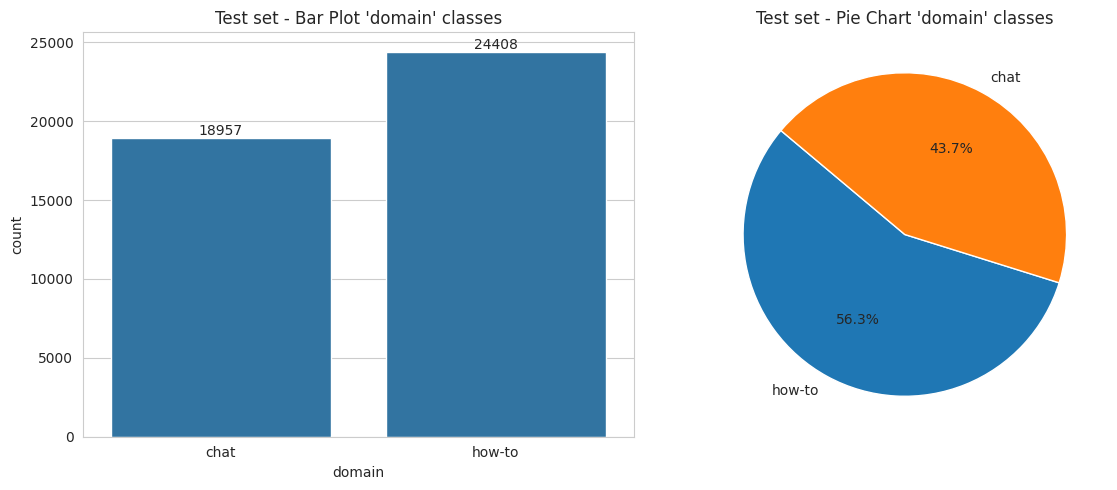

In [92]:
plot_multiple_charts(
    [
        lambda ax: sns.countplot(test_df, x="domain", ax=ax).bar_label(ax.containers[0]),

        lambda ax: ax.pie(test_df["domain"].value_counts(),
                          labels=test_df["domain"].value_counts().index,
                          autopct='%1.1f%%', startangle=140)
    ],
    titles=[
        "Test set - Bar Plot 'domain' classes",
        "Test set - Pie Chart 'domain' classes"],
    n_cols=2,
    figsize=(12, 5)
)

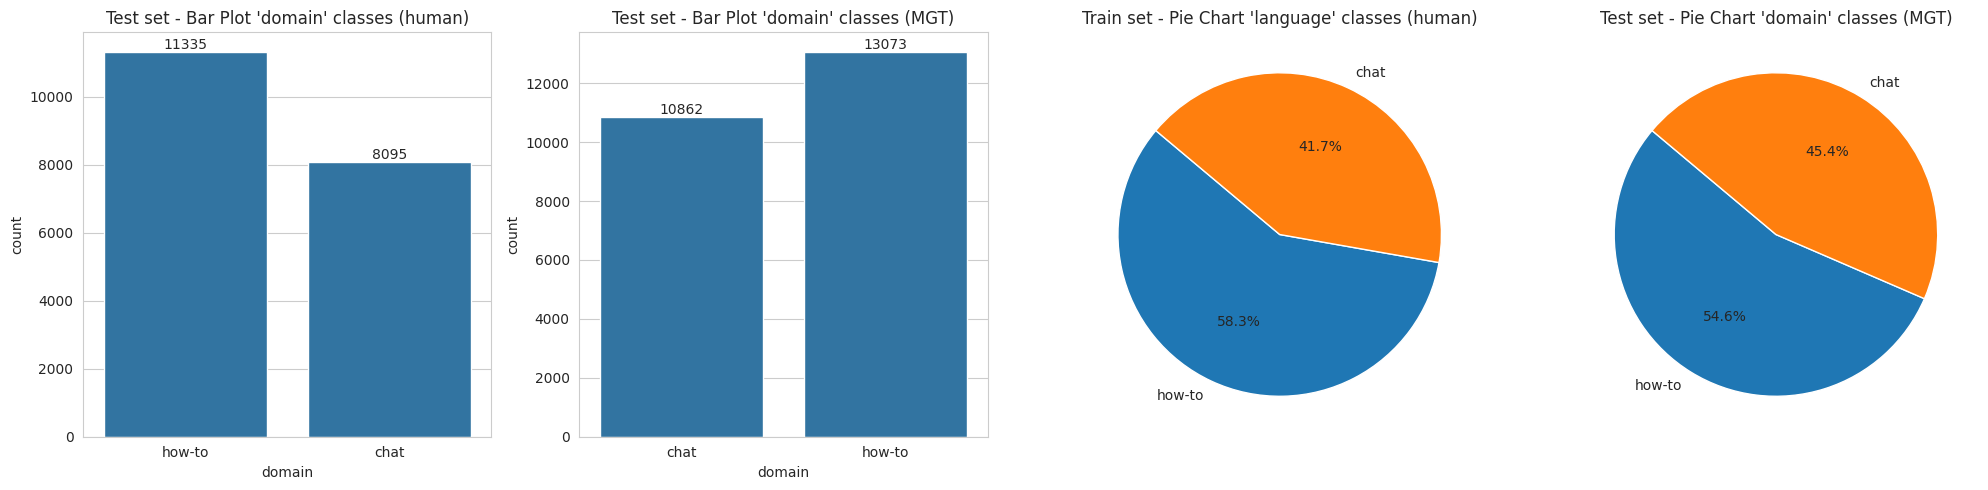

In [93]:
plot_multiple_charts(
    [
        lambda ax: sns.countplot(test_df_human, x="domain", ax=ax).bar_label(ax.containers[0]),
        lambda ax: sns.countplot(test_df_mgt, x="domain", ax=ax).bar_label(ax.containers[0]),
        lambda ax: ax.pie(test_df_human["domain"].value_counts(),
                          labels=test_df_human["domain"].value_counts().index,
                          autopct='%1.1f%%', startangle=140),
        lambda ax: ax.pie(test_df_mgt["domain"].value_counts(),
                          labels=test_df_mgt["domain"].value_counts().index,
                          autopct='%1.1f%%', startangle=140)

    ],
    titles=[
        "Test set - Bar Plot 'domain' classes (human)",
        "Test set - Bar Plot 'domain' classes (MGT)",
        "Train set - Pie Chart 'language' classes (human)",
        "Test set - Pie Chart 'domain' classes (MGT)",
    ],
    n_cols=4,
    figsize=(20, 5)
)

This is very strange. **We can see that for the test set, the domains are completely different than the ones used in the train set.**

Why is this the case? I have no idea. Maybe they wanted to see how capable to generalize to different domains these classifiers will be.

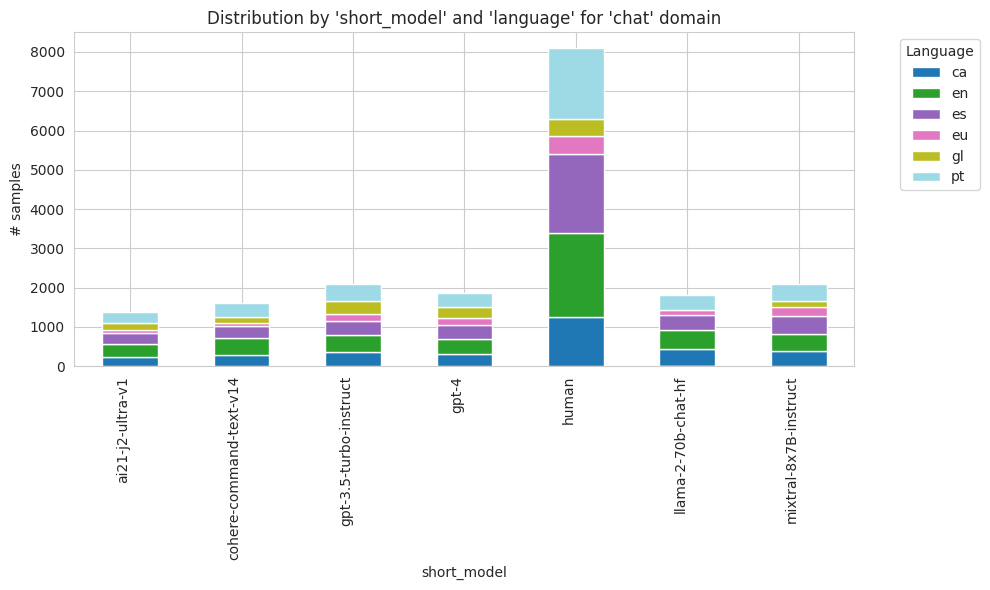

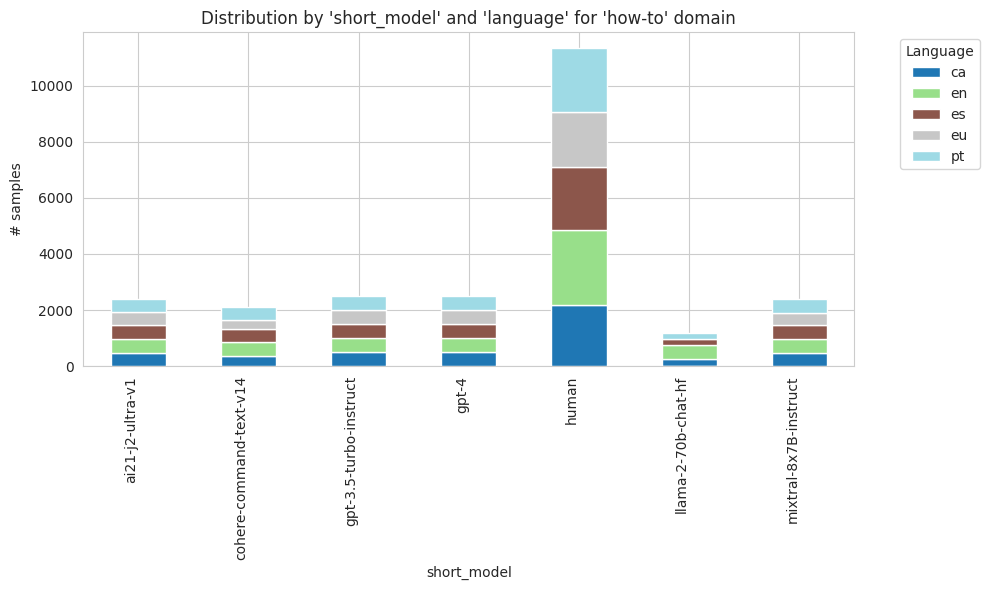

In [95]:
for domain in test_df["domain"].unique():
    plot_stacked_bar_for_domain(test_df, domain=domain)

We can also see how different models contribute to these domains in the test set as well for different languages.

We could keep analyzing the data more and more considering these extra dimensions like the "model", "language" and "domain". However, since we're focusing on the MGT detection task, I consider the analysis already done is good enough to move forward.

From now on, I will consider metrics that are more oriented to the `label` field alone, removing the `model` field from the equation for brevity.

Let's proceed now on analyzing a bit more the text that we have and on defining the pipelines to process the data that we will use for training our models in the following notebooks.


## Analysis of the Text for Each Class

If we want our models to be able to learn to predict the associated class based on the words in each document, we need to verify which words are most frequent for each class in our training set.

If there is a large overlap between the most common words across different classes, this could complicate the model's training, as it would see that the most representative words occur similarly across the classes. This is true if we consider frequency-based weighting. However, if we use **tf-idf**, this is not necessarily the case, since the weight a word carries in a review will depend not only on how many times it appears in that review but also on how often it occurs in the rest of the documents.

For ML-based approaches (baseline) we will probably choose TF-IDF right away as this is typically utilized in the industry.

On the other hand, we also need to check which words are most common in each class to see if they are truly representative and indicative of those classes or if they are unrelated.

In [56]:
top_more_popular_tokens: int = 25
train_set_more_pop_tokens_by_class: dict[str, pd.DataFrame] = get_more_common_tokens_by_class(df=train_df,
                                                                                              text_column_name="text",
                                                                                              label_column_name="label",
                                                                                              top_more_popular_tokens=top_more_popular_tokens)

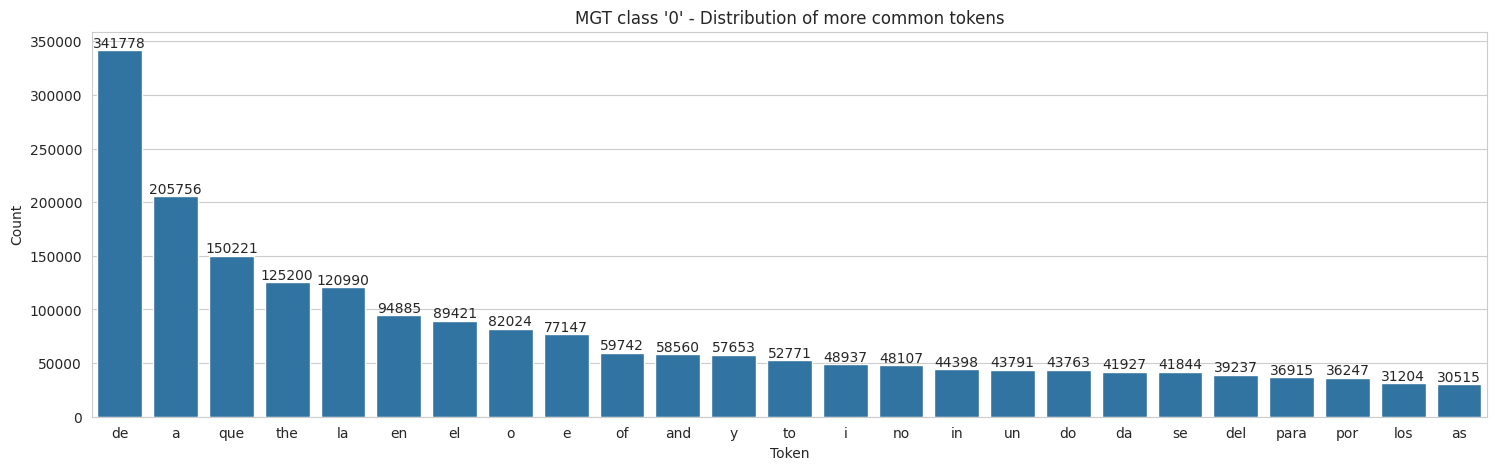

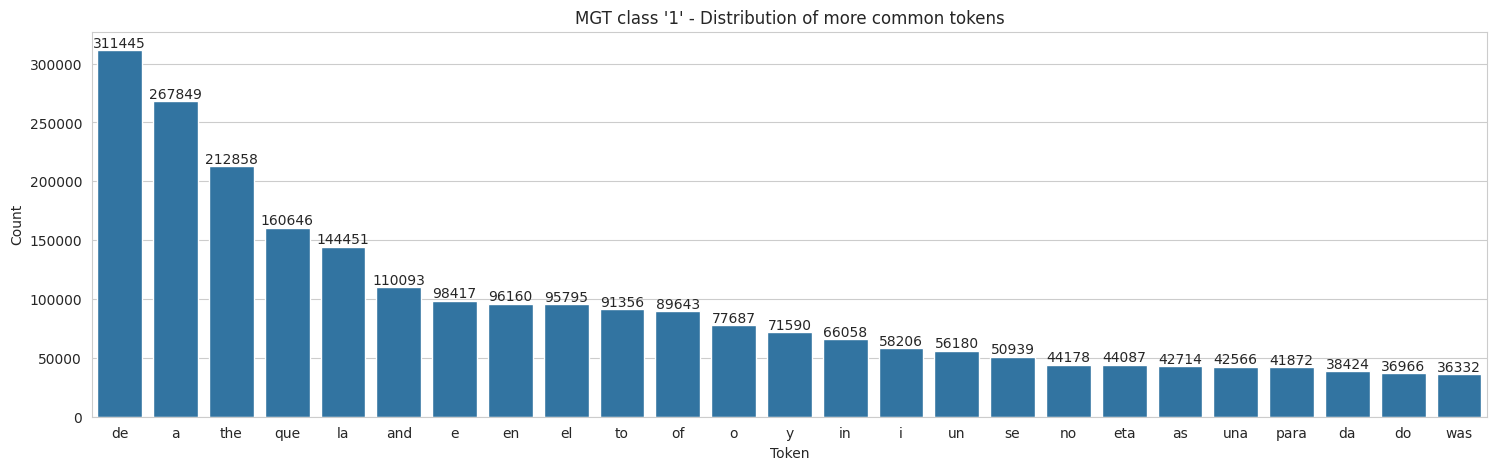

In [57]:
for class_label in list(train_set_more_pop_tokens_by_class.keys()):
    draw_barplot(x=train_set_more_pop_tokens_by_class[class_label]["token"],
                 y=train_set_more_pop_tokens_by_class[class_label]["count"],
                 figsize=(18, 5), x_label="Token",
                 title=f"MGT class '{class_label}' - Distribution of more common tokens")

In [58]:
# Compute overlap between more common tokens for hate and no_hate
more_pop_tokens_human: set[str] = set(train_set_more_pop_tokens_by_class[0]["token"])
more_pop_tokens_mgt: set[str] = set(train_set_more_pop_tokens_by_class[1]["token"])
intersection_set: set[str] = more_pop_tokens_human.intersection(more_pop_tokens_mgt)

print(
    f"Total different tokens that intersect between 'mgt' and 'human' classes in top {top_more_popular_tokens}: {len(intersection_set)}")
print(
    f"Intersection set between top {top_more_popular_tokens} more popular tokens for 'mgt' and 'human' classes: \n{intersection_set}")
print(
    f"Difference in top {top_more_popular_tokens} more popular tokens between 'mgt' and 'human': \n {more_pop_tokens_mgt.difference(more_pop_tokens_human)}")
print(
    f"Difference in top {top_more_popular_tokens} more popular tokens between 'mgt' and 'human': \n {more_pop_tokens_human.difference(more_pop_tokens_mgt)}")

Total different tokens that intersect between 'mgt' and 'human' classes in top 25: 22
Intersection set between top 25 more popular tokens for 'mgt' and 'human' classes: 
{'i', 'a', 'en', 'of', 'un', 'to', 'e', 'y', 'do', 'as', 'in', 'no', 'da', 'para', 'el', 'que', 'o', 'and', 'la', 'the', 'se', 'de'}
Difference in top 25 more popular tokens between 'mgt' and 'human': 
 {'una', 'eta', 'was'}
Difference in top 25 more popular tokens between 'mgt' and 'human': 
 {'los', 'del', 'por'}


In [59]:
train_set_more_pop_tokens_by_class[0]

,token,count
0,de,341778
1,a,205756
2,que,150221
3,the,125200
4,la,120990
5,en,94885
6,el,89421
7,o,82024
8,e,77147
9,of,59742


In [60]:
train_set_more_pop_tokens_by_class[1]

,token,count
0,de,311445
1,a,267849
2,the,212858
3,que,160646
4,la,144451
5,and,110093
6,e,98417
7,en,96160
8,el,95795
9,to,91356


As we can see, the top-25 more popular tokens between the "human" and "mgt" classes are very similar. Most of them are stopwords in the different languages. It could make sense to clean this up before trainign ML models.


💡 Note that when obtaining the most popular tokens, I performed a slight cleanup of the comments. I simply converted them to lowercase for clearer statistics and applied stripping.

## Distribution of the Number of Tokens in the Review Column

We will analyze the distribution of the number of words in each of our sets (it should be similar). We can start with a quick check by looking at the average at the character level.

We should verify the word distribution in both the training and test sets.

Then, within the training set, we could examine the distribution of the number of words for each class.

Notice that I'll be using a WhitespaceTokenizer. This is a simplification of course, as more advanced models use more complex tokenizers (sentence piece or wordpiece, etc.)

In [12]:
tokenizer = WhitespaceTokenizer()
train_df["tokens_count"] = train_df["text"].apply(lambda x: len(tokenizer.tokenize(x)))
test_df["tokens_count"] = test_df["text"].apply(lambda x: len(tokenizer.tokenize(x)))

In [106]:
train_df.head()

,id,prompt,text,label,domain,language,model,short_model,tokens_count
0,15442,Write a wikipedia article using the following ...,Es un tribunal de suprema instanza que forma p...,1,wikipedia,ca,cohere.command-text-v14,cohere-command-text-v14,237
1,26409,NO-PROMPT,Aixó de tindrer la platgeta tant prou era un p...,0,reviews,ca,human,human,13
2,12777,Write a wikipedia article using the following ...,Doug mcadam es un científico estadista estadou...,1,wikipedia,es,cohere.command-text-v14,cohere-command-text-v14,175
3,63467,Write a news article using the following summa...,"El president de la generalitat, carles puigdem...",1,news,ca,gpt-3.5-turbo-instruct,gpt-3.5-turbo-instruct,264
4,41050,Escribe un capítulo de libro que empieza por l...,"Traídas de francia, tan estrafalarias que una ...",1,literary,es,ai21.j2-ultra-v1,ai21-j2-ultra-v1,88


In [108]:
train_df[("tokens_count")].describe().reset_index()

,index,tokens_count
0,count,109663.000000
1,mean,171.309393
2,std,123.974667
3,min,10.000000
4,25%,48.000000
5,50%,157.000000
6,75%,279.000000
7,max,833.000000


In [19]:
tok_by_lang_train_df: pd.DataFrame = train_df.groupby("language")["tokens_count"].sum().reset_index().sort_values(
    by="tokens_count", ascending=False)
tok_by_lang_train_df

,language,tokens_count
1,en,5232805
2,es,4206364
5,pt,3424900
0,ca,2347738
4,gl,2001331
3,eu,1573164


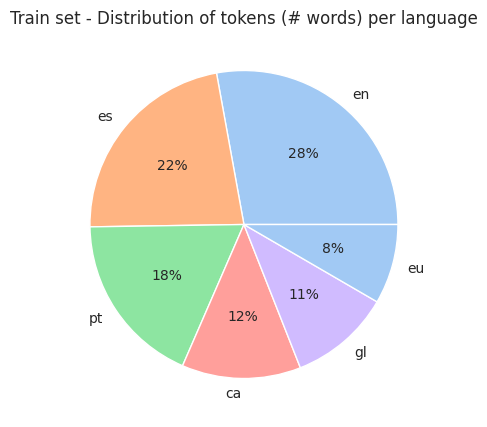

In [20]:
draw_pie_chart(counts=tok_by_lang_train_df["tokens_count"],
               labels=tok_by_lang_train_df["language"],
               title="Train set - Distribution of tokens (# words) per language",
               figsize=(5, 5))

Probably no surprise that English, Spanish and Portuguese are the languages that have more tokens in this context, as they have more samples than the rest of the languages.

In [21]:
test_df[("tokens_count")].describe().reset_index()

,index,tokens_count
0,count,43365.000000
1,mean,100.889312
2,std,100.409715
3,min,10.000000
4,25%,43.000000
5,50%,67.000000
6,75%,104.000000
7,max,533.000000


In [22]:
tok_by_lang_test_df: pd.DataFrame = test_df.groupby("language")["tokens_count"].sum().reset_index().sort_values(
    by="tokens_count", ascending=False)
tok_by_lang_test_df

,language,tokens_count
1,en,2052449
5,pt,698136
2,es,644255
0,ca,580206
3,eu,279011
4,gl,121008


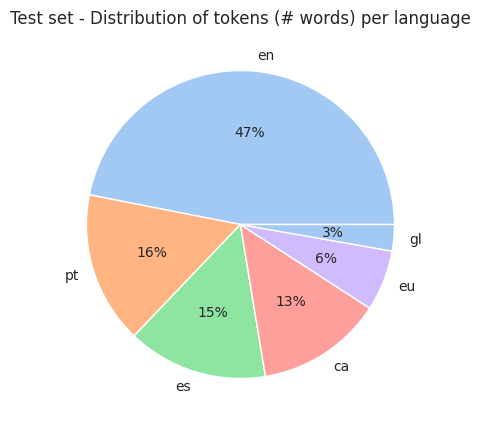

In [23]:
draw_pie_chart(counts=tok_by_lang_test_df["tokens_count"],
               labels=tok_by_lang_test_df["language"],
               title="Test set - Distribution of tokens (# words) per language",
               figsize=(5, 5))

This is interesting. Notice how English dominates considerably the number of tokens (words) for the test set. It's distributed a bit more evenly (not quite though) in the train set.

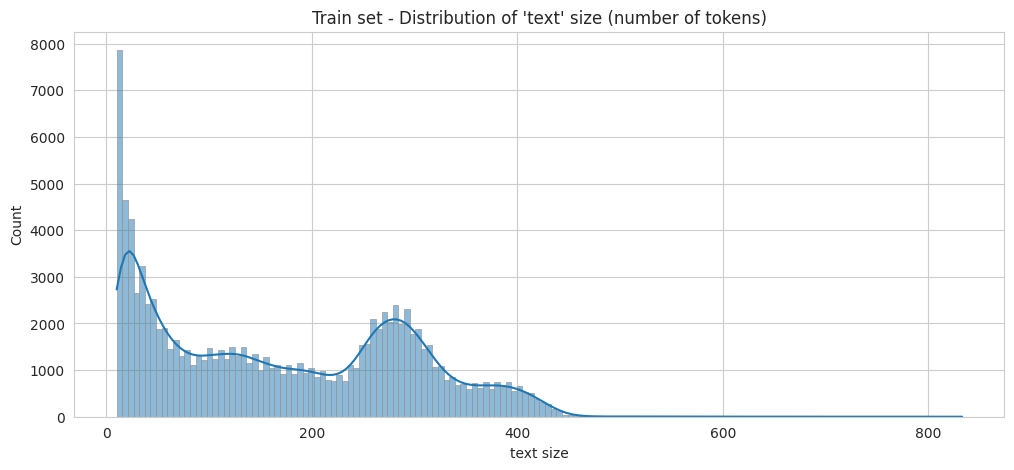

In [111]:
# Plot Train tokens distribution
draw_histogram(data=train_df["tokens_count"],
               title="Train set - Distribution of 'text' size (number of tokens)", x_label="text size",
               figsize=(12, 5), bins=150)

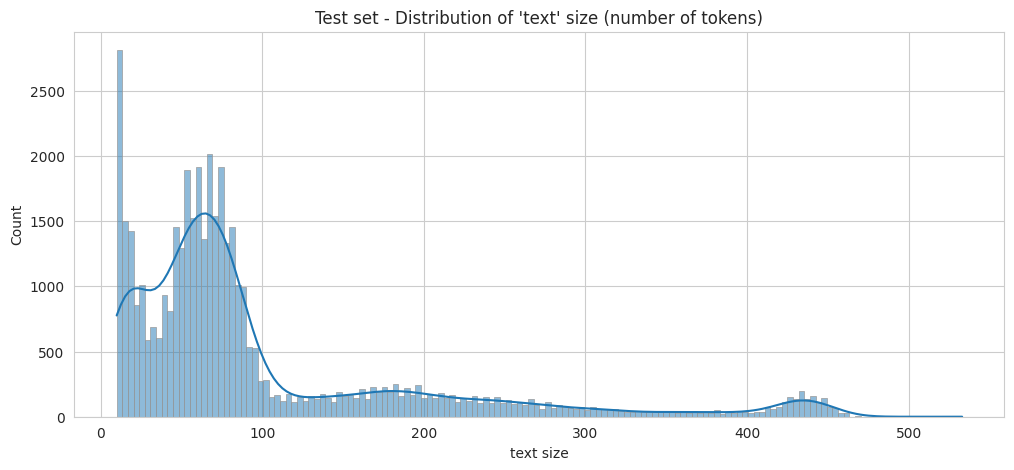

In [112]:
# Plot Test tokens distribution
draw_histogram(data=test_df["tokens_count"],
               title="Test set - Distribution of 'text' size (number of tokens)", x_label="text size",
               figsize=(12, 5),
               bins=150)

We can see that the distribution in terms of number of tokens in the generated texts differs between train and test, being considerably larger (in average) on the train set.

There are not many texts generated that contain over 500 tokens. On the other side, there's a fairly big number of elements that contain short answers (less then 100 words). Maybe we can inspect those and see what they're about.

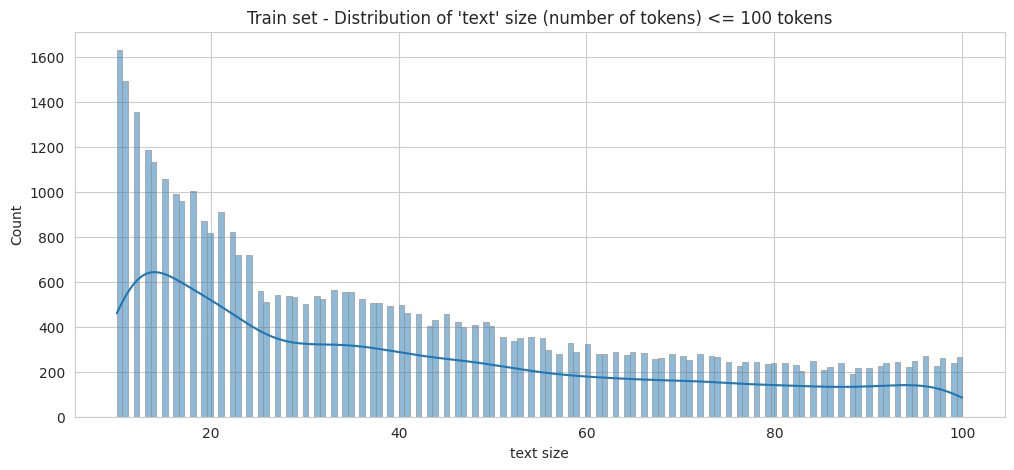

In [113]:
draw_histogram(data=train_df[train_df["tokens_count"] <= 100]["tokens_count"],
               title="Train set - Distribution of 'text' size (number of tokens) <= 100 tokens", x_label="text size",
               figsize=(12, 5), bins=150)

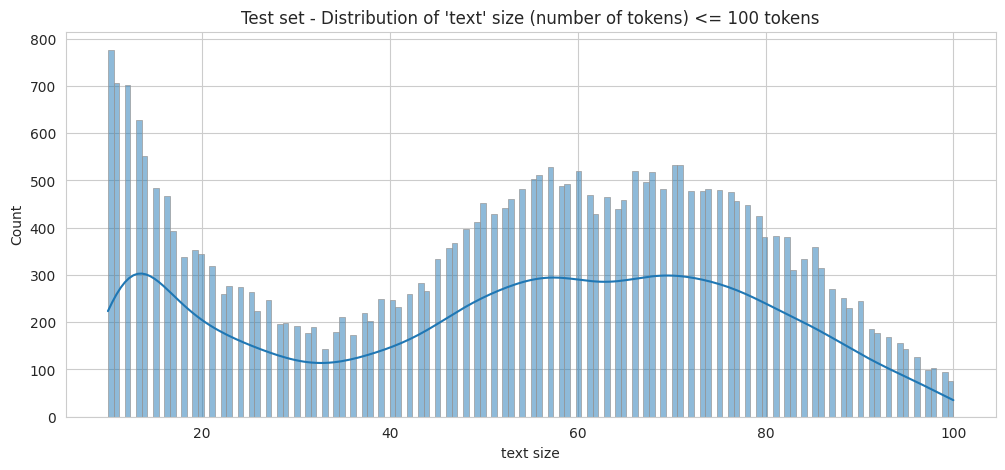

In [114]:
draw_histogram(data=test_df[test_df["tokens_count"] <= 100]["tokens_count"],
               title="Test set - Distribution of 'text' size (number of tokens) <= 100 tokens", x_label="text size",
               figsize=(12, 5), bins=150)

Now we will analyze the same distribution, but per class.

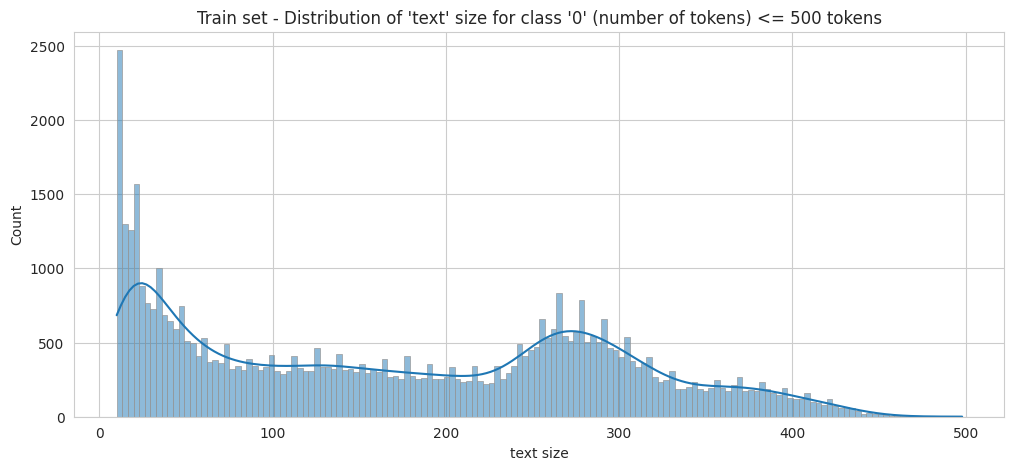

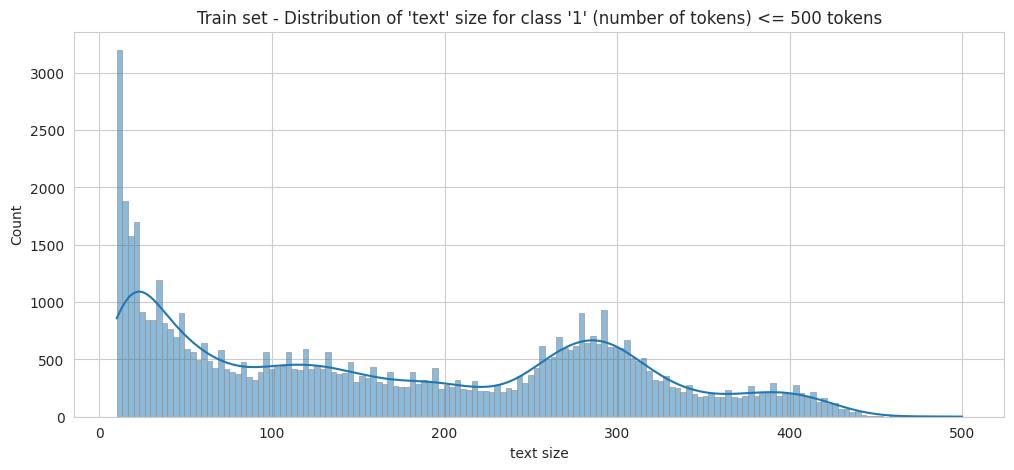

In [118]:
for class_label in sorted(set(train_df["label"])):
    draw_histogram(
        data=train_df[(train_df["label"] == class_label) & (train_df["tokens_count"] <= 500)]["tokens_count"],
        title=f"Train set - Distribution of 'text' size for class '{class_label}' (number of tokens) <= 500 tokens",
        x_label="text size",
        figsize=(12, 5), bins=150)

In [119]:
train_df[train_df["label"] == 1]["tokens_count"].describe()

count    58754.000000
mean       169.938251
std        125.127490
min         10.000000
25%         47.000000
50%        150.000000
75%        282.000000
max        833.000000
Name: tokens_count, dtype: float64

In [120]:
train_df[train_df["label"] == 0]["tokens_count"].describe()

count    50909.000000
mean       172.891827
std        122.612894
min         10.000000
25%         50.000000
50%        164.000000
75%        276.000000
max        771.000000
Name: tokens_count, dtype: float64

We can see that for the train set, the distribution in terms of number of words for "human" and "mgt" classes seems to be very similar.

We can very quickly visualize some short and long texts that were generated for each class.

In [13]:
sorted_train_df: pd.DataFrame = train_df.sort_values(by="tokens_count")

In [27]:
sorted_train_df[sorted_train_df["label"] == 0].head(5)

,id,prompt,text,label,domain,language,model,tokens_count
35359,141759,NO-PROMPT,"Bonito, leve e de ótima qualidade recomendo a ...",0,reviews,pt,human,10
41275,53214,NO-PROMPT,@naroa08_: no dije para siempre pero quien dij...,0,tweets,es,human,10
72650,111981,NO-PROMPT,@angelacalado cheia de dores de garganta .. ca...,0,tweets,pt,human,10
31324,13755,NO-PROMPT,Estoy ingiriendo las calorías que no me meto e...,0,tweets,es,human,10
92671,125653,NO-PROMPT,Produto de excelente custo beneficio para um s...,0,reviews,pt,human,10


In [28]:
sorted_train_df[sorted_train_df["label"] == 1].head(5)

,id,prompt,text,label,domain,language,model,tokens_count
29699,109326,Write a reply to this tweet: It's nice to thin...,"Rt @tylermallinson: it""s nice to think that #l...",1,tweets,en,cohere.command-text-v14,10
14311,60578,Write a reply in Portuguese to this tweet: @ne...,"Fala @nesitasplace420, eu também não sei muito...",1,tweets,pt,mistralai/Mixtral-8x7B-Instruct-v0.1,10
4040,92957,Write a tweet in Spanish using the user mentio...,"Risas interminables @keeila29, encuentro hombr...",1,tweets,es,gpt-4,10
94048,111884,"Write a hotel review with the following title,...",¡gran servicio! el personal es muy amable y at...,1,reviews,es,cohere.command-text-v14,10
86044,62337,Write a reply to this tweet: @pablopinto99 se ...,¡qué malas noticias! antunes no jugará contra ...,1,tweets,es,mistralai/Mixtral-8x7B-Instruct-v0.1,10


In [29]:
sorted_train_df[sorted_train_df["label"] == 0].tail(3)

,id,prompt,text,label,domain,language,model,tokens_count
58918,39470,NO-PROMPT,"O curso, que celebra a súa segunda edición, de...",0,news,gl,human,718
21921,55737,NO-PROMPT,A normalización efectuará as operacións de reo...,0,news,gl,human,738
21457,151248,NO-PROMPT,Coñécese co nome de rongorongo un sistema de e...,0,wikipedia,gl,human,771


In [31]:
list(sorted_train_df[sorted_train_df["label"] == 0].tail(3)["text"])

['O curso, que celebra a súa segunda edición, despois da celebrada no pasado mes de maio, xurde como unha necesidade formativa proposta polo grupo de intervención psicolóxica en catástrofes e emerxencias (gipce) do colexio oficial de psicoloxía de galicia, contando co recoñecemento sanitario da consellería de sanidade. nesta formación analizaranse as novas conceptualizacións sobre trauma, as reaccións individuais máis comúns ante este tipo de eventos que poden experimentar as persoas afectadas por unha traxedia, así como o tipo de trastornos psicolóxicos que poden ir asociados a situacións de crise, e os distintos tipos de intervención que se poden levar a cabo nestes casos. a docente responsable será a psicóloga clínica e investigadora dolores mosquera barral, figura de amplo recoñecemento nacional e internacional no eido dos traumas complexos e trastornos da personalidade, sendo tamén unha recoñecida especialista en terapias de nova xeración como terapia sensoriomotora, mindfulness o

In [32]:
sorted_train_df[sorted_train_df["label"] == 1].tail(3)

,id,prompt,text,label,domain,language,model,tokens_count
899,34065,Write a chapter of a book. The summary of the ...,"Mr. lorry sat in his room in paris, on the eve...",1,literary,en,ai21.j2-ultra-v1,723
12825,48846,Write a news article using the following summa...,Dairy farmers hit by a series of price cuts sa...,1,news,en,ai21.j2-ultra-v1,768
55392,129954,Write a wikipedia article using the following ...,Graeme hammond is a scottish professional foot...,1,wikipedia,en,ai21.j2-ultra-v1,833


In [33]:
list(sorted_train_df[sorted_train_df["label"] == 1].tail(3)["text"])

['Mr. lorry sat in his room in paris, on the evening of the 2nd of september, at least until it was nine o"clock. he sat there, brooding, without reading, without drinking, without smoking, and without speaking. he had been in paris since the morning, and had seen all the sights that had been described to him as worthy of his attention. he had dined at the famous restaurant in the palais royal, and had drunk wine there, and with wine, he had drunk a great deal of water. he had then walked about the streets, and had looked in at the shop windows, and had looked at the people, and had thought over and over again of the woman he loved. he had been thinking of her all day, and now, as he sat in his room, he was thinking of her more than ever. he was thinking of her, and of the way she had looked at him, and of the way she had smiled, and of the way she had kissed him, and of the way she had held his hand, and of the way she had held him. he was thinking of all these things, and of many oth

It's interesting to notice that two of the longest machine generated texts are basically the same sentence repeated over and over by the model.

### Validating duplicated comments

Let's check if there are duplicated texts in train or test. I will simply use lowercasing and stripping for this and remove any that might be there.

In [36]:
detect_column_duplicates(df=train_df)

Total unique 'text' with the same content for training set: 0
Total 'text' with the same content for training set: 0


,text,count,labels


In [37]:
detect_column_duplicates(df=test_df)

Total unique 'text' with the same content for training set: 0
Total 'text' with the same content for training set: 0


,text,count,labels


There are no duplicated texts in train or test sets.

### Caracters outside of ASCII

Let's validate if there are characters falling outisde of the [ASCII](https://www.w3schools.com/charsets/ref_html_ascii.asp#:~:text=ASCII%20is%20a%207%2Dbit,are%20all%20based%20on%20ASCII.).

In [40]:
train_df["ascii_only"] = train_df["text"].apply(lambda x: is_ascii(x))
train_df["non_ascii_chars"] = extract_non_valid_characters_from_df(df=train_df)
train_df["ascii_only"].describe().reset_index()

,index,ascii_only
0,count,109663
1,unique,2
2,top,False
3,freq,73775


In [42]:
test_df["ascii_only"] = test_df["text"].apply(lambda x: is_ascii(x))
test_df["non_ascii_chars"] = extract_non_valid_characters_from_df(df=test_df)
test_df["ascii_only"].describe().reset_index()

,index,ascii_only
0,count,43365
1,unique,2
2,top,False
3,freq,27767


In [43]:
print(
    f"Total rows in training set that contain non-ascii characters: {len(train_df) - len(train_df[train_df['ascii_only'] == True])}/{len(train_df)}")
print(
    f"Total rows in test set that contain non-ascii characters: {len(test_df) - len(test_df[test_df['ascii_only'] == True])}/{len(test_df)}")

Total rows in training set that contain non-ascii characters: 73775/109663
Total rows in test set that contain non-ascii characters: 27767/43365


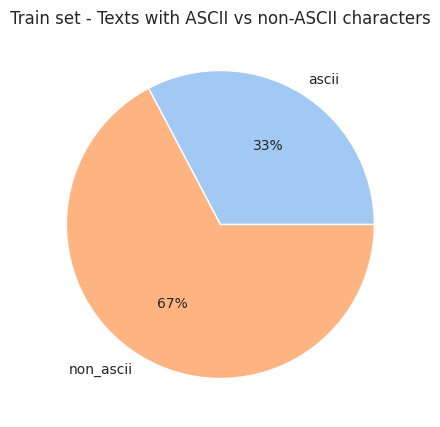

In [44]:
draw_pie_chart(counts=[len(train_df[train_df['ascii_only'] == True]),
                       len(train_df[train_df['ascii_only'] == False])],
               labels=["ascii", "non_ascii"],
               title="Train set - Texts with ASCII vs non-ASCII characters",
               figsize=(5, 5))

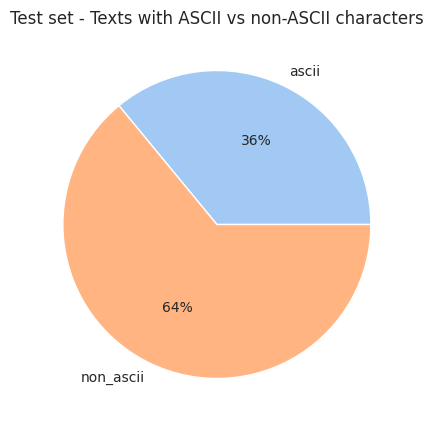

In [45]:
draw_pie_chart(counts=[len(test_df[test_df['ascii_only'] == True]),
                       len(test_df[test_df['ascii_only'] == False])],
               labels=["ascii", "non_ascii"],
               title="Test set - Texts with ASCII vs non-ASCII characters",
               figsize=(5, 5))

With this information, we can see that there are several texts both in train and test sets containing characters outside of the ASCII ones.

We will show some of them.

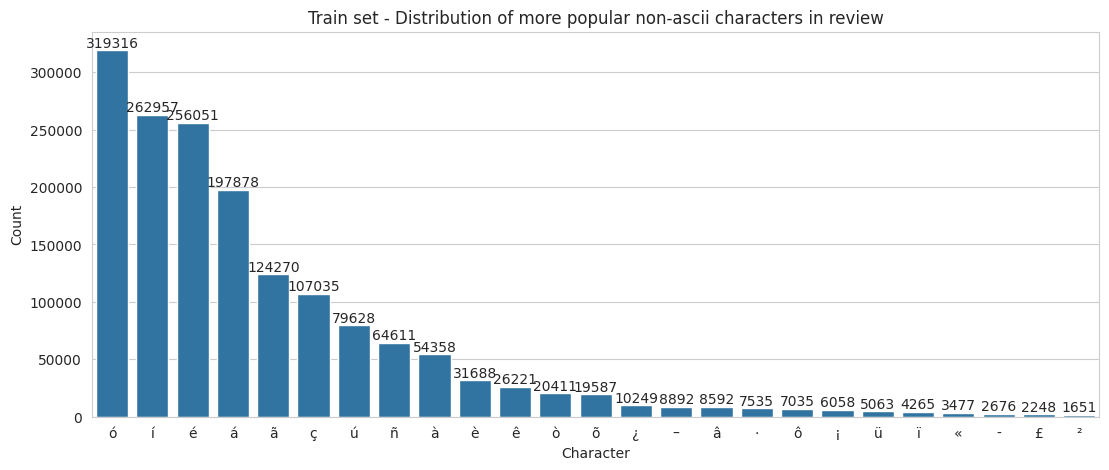

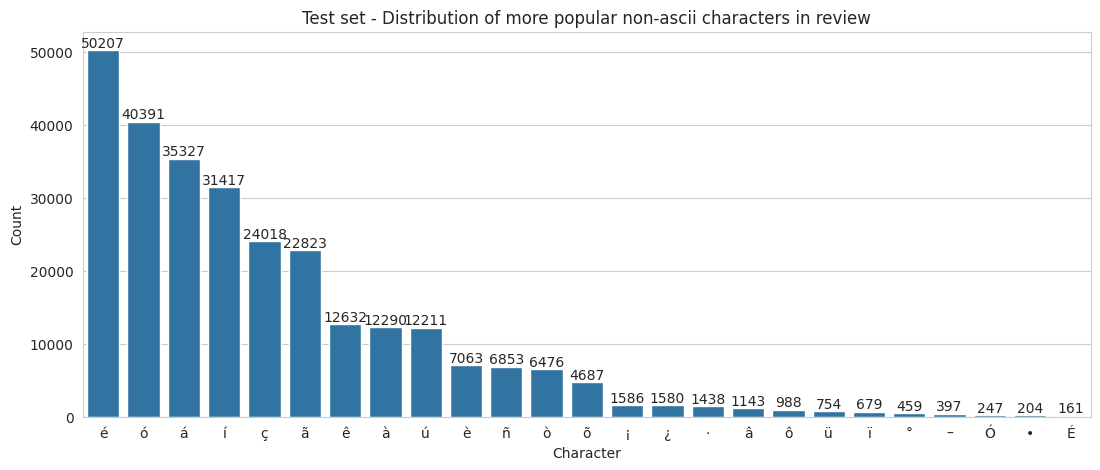

In [46]:
# Compute the distribution of the most common non-ascii characters in the train and test sets
for df, df_label in zip([train_df, test_df], ["Train", "Test"]):
    non_ascii_char_list = [char for sublist in df['non_ascii_chars'] for char in sublist]
    non_ascii_char_count: Counter = Counter(non_ascii_char_list)
    non_ascii_char_count_df: pd.DataFrame = pd.DataFrame(non_ascii_char_count.items(), columns=['char', 'count'])
    non_ascii_char_count_df = non_ascii_char_count_df.sort_values(by='count', ascending=False).head(25)

    draw_barplot(x=non_ascii_char_count_df["char"], y=non_ascii_char_count_df["count"],
                 title=f"{df_label} set - Distribution of more popular non-ascii characters in review",
                 x_label="Character", figsize=(13, 5))

To conclude this section, we can later decide what we want to do with these non-ASCII characters. Most of them correspond to diacritics, diaeresis or some other type of accent marks. We don't observe emojis in between the most popular ones.

We could very well decide to remove the diacritics when doing the cleanup in order not to lose the whole character. In other words, convert `é` to `e` for instance.

### Numerical Characters

An additional analysis that I consider valid before cleaning up the comments is to see in what contexts numbers are typically used within them.

In [48]:
train_df["contains_digits"] = train_df["text"].apply(lambda x: contains_digits(x))
train_df["digit_chars"] = extract_non_valid_characters_from_df(df=train_df,
                                                               validation_function=does_not_contain_digits)
train_df["contains_digits"].describe().reset_index()

,index,contains_digits
0,count,109663
1,unique,2
2,top,False
3,freq,56261


In [49]:
test_df["contains_digits"] = test_df["text"].apply(lambda x: contains_digits(x))
test_df["digit_chars"] = extract_non_valid_characters_from_df(df=test_df,
                                                              validation_function=does_not_contain_digits)
test_df["contains_digits"].describe().reset_index()

,index,contains_digits
0,count,43365
1,unique,2
2,top,False
3,freq,33354


In [50]:
print(
    f"Total rows in training set that contain digits: {len(train_df[train_df['contains_digits'] == True])}/{len(train_df)}")
print(
    f"Total rows in test set that contain digits: {len(test_df[test_df['contains_digits'] == True])}/{len(test_df)}")

Total rows in training set that contain digits: 53402/109663
Total rows in test set that contain digits: 10011/43365


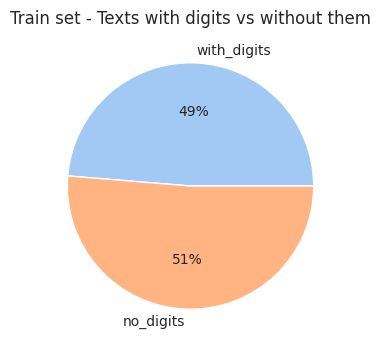

In [51]:
draw_pie_chart(counts=[len(train_df[train_df['contains_digits'] == True]),
                       len(train_df[train_df['contains_digits'] == False])],
               labels=["with_digits", "no_digits"],
               title="Train set - Texts with digits vs without them",
               figsize=(4, 4))

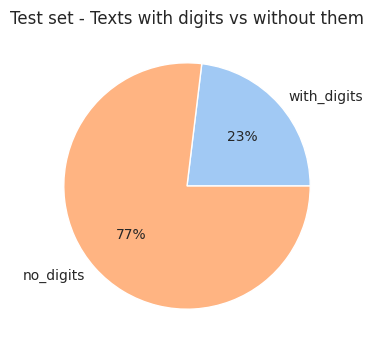

In [52]:
draw_pie_chart(counts=[len(test_df[test_df['contains_digits'] == True]),
                       len(test_df[test_df['contains_digits'] == False])],
               labels=["with_digits", "no_digits"],
               title="Test set - Texts with digits vs without them",
               figsize=(4, 4))

In [54]:
samples: pd.DataFrame = train_df[train_df["contains_digits"] == True].sample(3)
for s in samples["text"]:
    print(s)
samples

24durangoko azokaren 50. urteurrenean, hiru erreakziomekaguendios, ja pentsatzen nian inork ez zidaala galdera puta hori egin behar , laostia. burua jaten ibili nauk ze ostiagatik ez ote dik inork bideo puta nazkagarri hori aipatu ere egin pentsatuaz. ni twitter ni letxes, inork ez dik inon aipatu, laostia. pozten nauk galdetu didaalako, gazte, pozten nauk, laostia. aber , entzun. pentsatze hutsarekin etortzen zaidak botalarria, pentsatze hutsarekin, ulertzen didak? halako kilima nazkagarri bat sartzen zaidak gorputzean aurpegi haiekineta, hitz haiekineta akordat zean. ikusten nola puzten zaidaken lepoko zaina? serio esaten diat: buruan falta zaioan ile guztia eta askoz ere gehiago gorputzean zehar kizkurtuta zauzkaken gizon batek besoa eztarritik sartu eta sabelean ostiako nazkagarri bat emango balit bezala sentiarazten naik. botalarria ematen zidak. kalakaneko tximasa ikusi eta esan nian «joder , hasi gaituk , piura hipster horiekin eta artzain xiberotarraren azentoarekin, no me joda

,id,prompt,text,label,domain,language,model,tokens_count,ascii_only,non_ascii_chars,contains_digits,digit_chars
97943,3572,NO-PROMPT,"24durangoko azokaren 50. urteurrenean, hiru er...",0,literary,eu,human,206,False,"[«, ñ, ñ, «]",True,"[2, 4, 5, 0]"
93639,10622,NO-PROMPT,"Charles ali (23 de agosto de 1984 en san luis,...",0,wikipedia,es,human,111,False,"[ú, ó, ó, ó, é, ó, í, ú]",True,"[2, 3, 1, 9, 8, 4, 2, 0, 0, 7]"
10454,113406,NO-PROMPT,"El hotel es muy bueno , lo mejor que tiene es ...",0,reviews,es,human,40,True,[],True,[3]


### HTML Tags

We could check for the presence of HTML tags in our data and consider this as a possible cleaning criterion.

For this, we will use a well-known library called [BeautifulSoup](https://pypi.org/project/beautifulsoup4/#:~:text=Beautiful%20Soup%20is%20a%20library,and%20modifying%20the%20parse%20tree.) to detect HTML tags in general and also in case we want to clean them.

In [60]:
train_df["contains_html_tags"] = train_df["text"].apply(lambda x: contains_html_tags(x))
train_df["html_tags"] = extract_html_tags_from_df(df=train_df)
train_df["contains_html_tags"].describe().reset_index()

/tmp/ipykernel_117707/2340777990.py:74: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup: BeautifulSoup = BeautifulSoup(html_str, 'html.parser')


,index,contains_html_tags
0,count,109663
1,unique,2
2,top,False
3,freq,109548


In [61]:
test_df["contains_html_tags"] = test_df["text"].apply(lambda x: contains_html_tags(x))
test_df["html_tags"] = extract_html_tags_from_df(df=test_df)
test_df["contains_html_tags"].describe().reset_index()

/tmp/ipykernel_117707/2340777990.py:74: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup: BeautifulSoup = BeautifulSoup(html_str, 'html.parser')
/tmp/ipykernel_117707/2340777990.py:74: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup: BeautifulSoup = BeautifulSoup(html_str, 'html.parser')


,index,contains_html_tags
0,count,43365
1,unique,2
2,top,False
3,freq,43249


In [62]:
print(
    f"Total rows in training set that contain HTML tags: {len(train_df[train_df['contains_html_tags'] == True])}/{len(train_df)}")
print(
    f"Total rows in test set that contain HTML tags: {len(test_df[test_df['contains_html_tags'] == True])}/{len(test_df)}")

Total rows in training set that contain HTML tags: 115/109663
Total rows in test set that contain HTML tags: 116/43365


There are very few samples containing HTML tags both in train and test sets.

In [65]:
list(train_df[train_df["contains_html_tags"]].sample(10)["text"])

['Baina, <kask kask kask!> entzun zuten berriz ere denek. –banoa, banoa! –esan zue n aitak eta ate aldera abiatu zen. –kontxo, agustin! zer habil hemen? sendatu al haiz, ba? –aitak. –bai, bai, oso ongi nagok, eskerrik asko! – morroiak –. baina, aizak, gauza bat, manex etxean al da? –bai, bai, hementxe zagok, noski, familia osoa bazkaltzen ari baikinen –aitak, pixka bat harriturik, morroia ordu hartan hantxe ikusita –. zer, ba?, arazoren bat? –ez, ez! alderantziz, lasai! –agustinek, irribarrez. –ai!, baina, barkatu! tira, tira, sartu barrenera! –aitak, irri abegikorrez. behin suk aldean, bisitariak poltsatxo bat agertu eta handik esku erakutsi batzuk atera zituen. –balin batzuk eta txanpon hauek manexentzat ekarri ditut –esan zuen denen aurrean pozik –. hauekin nire esker ona azaldu nahi diot, lehengo egunean eman zidan doaneko lag untzarengatik. –hator, hator, manex!, har itzak opari txiki hauek! –eta, balinak eta duro batzuk',
 'Merry-la-vallée frantziako udalerria da, yonne departame

There are some HTML tags in these examples, like `<noinclude>` and some false positives generated by the Euskera (like `<kask kask kask!>`).

We're fine with this, probably no point in even consider to clean them out.


### URL addresses

In [66]:
train_df["contains_urls"] = train_df["text"].apply(lambda x: contains_url(x))
train_df["contains_urls"].describe().reset_index()

,index,contains_urls
0,count,109663
1,unique,2
2,top,False
3,freq,109291


In [67]:
test_df["contains_urls"] = test_df["text"].apply(lambda x: contains_url(x))
test_df["contains_urls"].describe().reset_index()

,index,contains_urls
0,count,43365
1,unique,2
2,top,False
3,freq,43136


In [68]:
print(
    f"Total rows in training set that contain URLs: {len(train_df[train_df['contains_urls'] == True])}/{len(train_df)}")
print(
    f"Total rows in test set that contain URLs: {len(test_df[test_df['contains_urls'] == True])}/{len(test_df)}")

Total rows in training set that contain URLs: 372/109663
Total rows in test set that contain URLs: 229/43365


In [69]:
samples = train_df[train_df["contains_urls"] == True].head(5)
for sample in list(samples["text"]):
    print(f"Sample: '{sample}'  || URLs: '{find_urls(sample)}'")

Sample: 'Santa clara battery is a historic coastal artillery battery located in santa clara, california. the battery was built in the late 19th century to protect the city from potential attacks on the pacific coast. it is one of the few surviving examples of a coastal artillery battery in the bay area. the battery was designed by major joseph k. mansfield and completed in 1886. it was armed with two 10-inch rodman guns and two 5-inch converted brooke guns. the battery was originally part of the santa cruz artillery company, which later became the coast artillery corps of the united states army. the battery was operational until 1940 when its weapons were removed. it was later declared surplus and sold to the city of santa clara, which used it as a park. the battery"s two 10-inch guns were later transferred to the united states army corps of engineers and used as coastal artillery at fort macarthur and fort ross. the battery is now part of the santa clara central park and is listed on 

There are also some urls present in the texts. As they come from different domains, they might add some sort of value.

## Conclusions from the Initial Exploration

- There is a presence of and non-ASCII characters (a large percentage).
- We need to decide what to do with punctuation and special characters.
- There are very noisy messages (we found some examples in the MGT category of the same sentence repeated over and over).
- Some messages include URLs.
- There's barely any presence of HTML tags (most of the time false positives of the Euskera language), so it’s not necessary to consider them for cleanup.






# Cleanup and Pre-processing of text

When working with a heterogeneous dataset like this one, which aggregates human text from varied sources (ranging from news articles and literary texts to tweets and Wikipedia) and pairs them with machine-generated counterparts from multiple language models—it’s important to balance normalization with the preservation of stylistic nuances that may be key signals for classification. In this case, I will opt for trying to keep as much information as possible and I will not apply or consider stemming or lemmatization.

Having said this, I would suggest a light cleanup for both ML and DL approaches, with some distinctions:
- **ML approaches (baseline)**: For classical ML pipelines that rely on feature extraction (e.g., TF-IDF vectors, n-grams), a bit more or preprocessing could be done:
  - Lowercasing.
  - Unicode normalization.
  - URL removal.
  - Space normalization.
  - Removing stopwords from different languages.
  - Could consider to remove HTML tags, even though there're multiple false positives.
- **DL approaches**: Deep neural models (e.g., transformer-based classifiers) are often robust to “noisy” inputs because they learn complex representations directly from raw text. For these models, the cleanup will be even lighter and might include only space normalization.

Notice that for DL approaches I'm not applying lowercasing (as I want to use and keep the information provided by capital letters and I'm not also applying unicode normalization or stopword removal).

**Stopwords considerations**

💡 For stopword removal (and maybe this could apply to other rules as well), we should consider the language. That's why you will see that the cleaner not only receives the text to clean but the language in which that text is in.

There are some languages for which getting a list of stopwords might not be as simple (for others, `stopwords` from NLTK will do it). Because of this, I will analyze some libraries and try to determine a good list for each.




In [20]:
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [21]:
stopwords.words("spanish")

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [22]:
stopwords.words("portuguese")

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

In [23]:
stopwords.words("catalan")

['a',
 'abans',
 'ací',
 'ah',
 'així',
 'això',
 'al',
 'aleshores',
 'algun',
 'alguna',
 'algunes',
 'alguns',
 'alhora',
 'allà',
 'allí',
 'allò',
 'als',
 'altra',
 'altre',
 'altres',
 'amb',
 'ambdues',
 'ambdós',
 'anar',
 'ans',
 'apa',
 'aquell',
 'aquella',
 'aquelles',
 'aquells',
 'aquest',
 'aquesta',
 'aquestes',
 'aquests',
 'aquí',
 'baix',
 'bastant',
 'bé',
 'cada',
 'cadascuna',
 'cadascunes',
 'cadascuns',
 'cadascú',
 'com',
 'consegueixo',
 'conseguim',
 'conseguir',
 'consigueix',
 'consigueixen',
 'consigueixes',
 'contra',
 "d'un",
 "d'una",
 "d'unes",
 "d'uns",
 'dalt',
 'de',
 'del',
 'dels',
 'des',
 'des de',
 'després',
 'dins',
 'dintre',
 'donat',
 'doncs',
 'durant',
 'e',
 'eh',
 'el',
 'elles',
 'ells',
 'els',
 'em',
 'en',
 'encara',
 'ens',
 'entre',
 'era',
 'erem',
 'eren',
 'eres',
 'es',
 'esta',
 'estan',
 'estat',
 'estava',
 'estaven',
 'estem',
 'esteu',
 'estic',
 'està',
 'estàvem',
 'estàveu',
 'et',
 'etc',
 'ets',
 'fa',
 'faig',
 'f

In [29]:
stopwords.words("galician")

OSError: No such file or directory: '/home/lucas/nltk_data/corpora/stopwords/galician'

In [30]:
stopwords.words("euskera")

OSError: No such file or directory: '/home/lucas/nltk_data/corpora/stopwords/euskera'

For Galician and Euskera, they don't provide stopwords. There's a library called [stopwords-iso](https://github.com/stopwords-iso/stopwords-iso) that might help us.
We could also grab them from the internet.

In [33]:
stopwordsiso.stopwords("gl")

{'a',
 'alí',
 'ao',
 'aos',
 'aquel',
 'aquela',
 'aquelas',
 'aqueles',
 'aquilo',
 'aquí',
 'as',
 'así',
 'aínda',
 'ben',
 'cando',
 'che',
 'co',
 'coa',
 'coas',
 'comigo',
 'con',
 'connosco',
 'contigo',
 'convosco',
 'cos',
 'cun',
 'cunha',
 'cunhas',
 'cuns',
 'da',
 'dalgunha',
 'dalgunhas',
 'dalgún',
 'dalgúns',
 'das',
 'de',
 'del',
 'dela',
 'delas',
 'deles',
 'desde',
 'deste',
 'do',
 'dos',
 'dun',
 'dunha',
 'dunhas',
 'duns',
 'e',
 'el',
 'ela',
 'elas',
 'eles',
 'en',
 'era',
 'eran',
 'esa',
 'esas',
 'ese',
 'eses',
 'esta',
 'estaba',
 'estar',
 'este',
 'estes',
 'estiven',
 'estou',
 'está',
 'están',
 'eu',
 'facer',
 'foi',
 'foron',
 'fun',
 'había',
 'hai',
 'iso',
 'isto',
 'la',
 'las',
 'lle',
 'lles',
 'lo',
 'los',
 'mais',
 'me',
 'meu',
 'meus',
 'min',
 'miña',
 'miñas',
 'moi',
 'na',
 'nas',
 'neste',
 'nin',
 'no',
 'non',
 'nos',
 'nosa',
 'nosas',
 'noso',
 'nosos',
 'nun',
 'nunha',
 'nunhas',
 'nuns',
 'nós',
 'o',
 'os',
 'ou',
 'para

In [34]:
stopwordsiso.stopwords("eu")

{'al',
 'anitz',
 'arabera',
 'asko',
 'baina',
 'bat',
 'batean',
 'batek',
 'bati',
 'batzuei',
 'batzuek',
 'batzuetan',
 'batzuk',
 'bera',
 'beraiek',
 'berau',
 'berauek',
 'bere',
 'berori',
 'beroriek',
 'beste',
 'bezala',
 'da',
 'dago',
 'dira',
 'ditu',
 'du',
 'dute',
 'edo',
 'egin',
 'ere',
 'eta',
 'eurak',
 'ez',
 'gainera',
 'gu',
 'gutxi',
 'guzti',
 'haiei',
 'haiek',
 'haietan',
 'hainbeste',
 'hala',
 'han',
 'handik',
 'hango',
 'hara',
 'hari',
 'hark',
 'hartan',
 'hau',
 'hauei',
 'hauek',
 'hauetan',
 'hemen',
 'hemendik',
 'hemengo',
 'hi',
 'hona',
 'honek',
 'honela',
 'honetan',
 'honi',
 'hor',
 'hori',
 'horiei',
 'horiek',
 'horietan',
 'horko',
 'horra',
 'horrek',
 'horrela',
 'horretan',
 'horri',
 'hortik',
 'hura',
 'izan',
 'ni',
 'noiz',
 'nola',
 'non',
 'nondik',
 'nongo',
 'nor',
 'nora',
 'ze',
 'zein',
 'zen',
 'zenbait',
 'zenbat',
 'zer',
 'zergatik',
 'ziren',
 'zituen',
 'zu',
 'zuek',
 'zuen',
 'zuten'}

In [37]:
class LanguageCode(StrEnum):
    ENGLISH = "en"
    SPANISH = "es"
    PORTUGUESE = "pt"
    CATALAN = "ca"
    GALICIAN = "gl"
    EUSKERA = "eu"


STOPWORDS: dict[LanguageCode, set[str]] = {
    LanguageCode.ENGLISH: set(stopwords.words("english")),
    LanguageCode.SPANISH: set(stopwords.words("spanish")),
    LanguageCode.PORTUGUESE: set(stopwords.words("portuguese")),
    LanguageCode.CATALAN: set(stopwords.words("catalan")),
    LanguageCode.GALICIAN: set(stopwordsiso.stopwords("gl")),
    LanguageCode.EUSKERA: set(stopwordsiso.stopwords("eu")),
}

STOPWORDS

{<LanguageCode.ENGLISH: 'en'>: {'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  'aren',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  'couldn',
  "couldn't",
  'd',
  'did',
  'didn',
  "didn't",
  'do',
  'does',
  'doesn',
  "doesn't",
  'doing',
  'don',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'had',
  'hadn',
  "hadn't",
  'has',
  'hasn',
  "hasn't",
  'have',
  'haven',
  "haven't",
  'having',
  'he',
  'her',
  'here',
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  'i',
  'if',
  'in',
  'into',
  'is',
  'isn',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  'just',
  'll',
  'm',
  'ma',
  'me',
  'mightn',
  "mightn't",
  'more',
  'most',
  'mustn',
  "mustn't",
  'my',
  'myself',
  'needn',
  "needn't",
  'no',
  'nor',
  'not',
  'n

In [39]:
STOPWORDS[LanguageCode.ENGLISH]

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In order to make this simpler, I'll create a cleanup class that we can use and pass the dataset through it. Outputs will be stored in the `experiment_output` folder.

In [18]:
@dataclass
class CleaningConfig:
    keep_letters_only: bool = False
    """ If True, it will remove all characters that are not letters """
    remove_digits: bool = False
    """ If True, numbers will be removed"""
    remove_punctuation: bool = True
    """ If True, punctuation will be removed """
    normalize_casing: bool = True
    """ If True, the input will be lowercased """
    normalize_unicode_string: bool = True
    """ If True, we'll normalize the unicode string """
    remove_urls: bool = True
    """ If True, it will get rid of urls present in the string """
    remove_stopwords: bool = True
    """ If True, stopwords in English will be removed """
    remove_unicode_symbols: bool = False
    """ If True, unicode symbols will be removed """
    replace_diacritics: bool = False
    """ If True, diacritics will be replaced by their regular non accentuated character version, so they're not lost """
    apply_lemmatization: bool = False
    """  If True, lemmatization will be applied"""
    apply_stemming: bool = False
    """ If True, stemming will be applied """
    stopwords: dict[LanguageCode, set[str]] | None = field(default_factory=lambda: STOPWORDS)
    """ Mandatory if remove_stopwords is True. Dictionary that goes for each language ISO code to the set of stopwords to use for that language. """

    def __post_init__(self):
        if self.remove_stopwords:
            validate_condition(condition=self.stopwords != {},
                               msg=f"Stopwords have to be provided if 'remove_stopwords' is True")


class TextCleaner:
    """ Review cleaner, that allows us to easily configure the rules to be applied in each cleanup """

    def __init__(self, cleaning_config: CleaningConfig) -> None:
        self._config: CleaningConfig = cleaning_config
        if self._config.apply_lemmatization:
            self._lemmatizer: Language = spacy.load("es_core_news_sm")

        if self._config.apply_stemming:
            self._stemmer: SnowballStemmer = SnowballStemmer("spanish")

        if self._keep_letters_only:
            self._letters_pattern = re.compile(r'[^a-zA-Z ]+')

    def clean(self, original_sample: str, lang_code: LanguageCode) -> str:
        """
        Returns a cleaned version of the received sample. It could happen that the string ends up being an empty string after the cleanup
        If this is the case, our logic could maintain the original string as is.
        """
        sample: str = original_sample

        if self._config.normalize_unicode_string:
            sample = self._normalize_unicode_string(sample)
        if self._config.normalize_casing:
            sample = self._normalize_case(sample)
        if self._config.remove_urls:
            sample = self._remove_urls(sample)
        if self._config.keep_letters_only:
            sample = self._keep_letters_only(sample)
        else:
            # We offer more granularity in terms of the level of detail of what we exactly want to clean
            if self._config.replace_diacritics:
                sample = self._replace_diacritics(sample)
            if self._config.remove_unicode_symbols:
                sample = self._remove_unicode_symbols(sample)
            if self._config.remove_digits:
                sample = self._remove_digits(sample)
            if self._config.remove_punctuation:
                sample = self._remove_punctuation(sample)

        if self._config.remove_stopwords:
            sample = self._remove_stopwords(sample, lang_code)
        if self._config.apply_lemmatization:
            sample = self._apply_lemmatization(sample)
        if self._config.apply_stemming:
            sample = self._apply_stemming(sample)

        # Normalize whitespaces and finish
        return " ".join(sample.strip().split())

    @staticmethod
    def _normalize_unicode_string(sample: str) -> str:
        # Unicode NFKD normalization
        return unicodedata.normalize('NFKD', sample)

    @staticmethod
    def _normalize_case(sample: str) -> str:
        return sample.lower()

    @staticmethod
    def _remove_unicode_symbols(sample: str) -> str:
        return sample.encode("ascii", "ignore").decode()

    @staticmethod
    def _replace_diacritics(sample: str) -> str:
        sample = re.sub("à|á|â|ã|ä|å", 'a', sample)
        sample = re.sub("è|é|ê|ë", 'e', sample)
        sample = re.sub("ì|í|î|ï", 'i', sample)
        sample = re.sub("ò|ó|ô|õ|ö", 'o', sample)
        sample = re.sub("ù|ú|û|ü", 'u', sample)
        sample = re.sub("ý|ÿ", 'y', sample)
        sample = re.sub("ß", 'ss', sample)
        sample = re.sub("ñ", 'n', sample)

        return sample

    @staticmethod
    def _remove_digits(sample: str) -> str:
        pattern = r'[0-9]'
        # Match all digits in the string and replace them with an empty string
        return re.sub(pattern, "", sample)

    def _keep_letters_only(self, sample: str) -> str:
        return re.sub(self._letters_pattern, "", sample)

    @staticmethod
    def _remove_punctuation(sample: str) -> str:
        punctuation: str = string.punctuation.replace("#", "") + "¡"  # Keep this as it's used in hashtags
        return "".join([char for char in sample if char not in punctuation])

    @staticmethod
    def _remove_html_tags(sample: str) -> str:
        return BeautifulSoup(sample).get_text()

    @staticmethod
    def _remove_urls(sample: str) -> str:
        urls: list[str] = find_urls(sample)
        proc_sample: str = sample
        for url in urls:
            proc_sample = proc_sample.replace(url, "")
        return proc_sample

    def _remove_stopwords(self, sample: str, lang_code: LanguageCode) -> str:
        # Get stopwords specific to that language, if given!
        stopwords: set[str] = self._config.stopwords.get(lang_code, set())
        return " ".join([w for w in sample.split() if w not in stopwords])

    def _apply_lemmatization(self, sample: str) -> str:
        doc = self._lemmatizer(sample)
        return " ".join([token.lemma_ for token in doc])

    def _apply_stemming(self, sample: str) -> str:
        words = nltk.word_tokenize(sample)
        return " ".join([self._stemmer.stem(word) for word in words])


# Check distribution of tokens after some ML-like cleanup

Let's repeat the most popular tokens per class, this time, after the cleanup.

In [44]:
%%time
cleaner: TextCleaner = TextCleaner(CleaningConfig(
    keep_letters_only=False,
    remove_digits=False,
    remove_punctuation=True,
    normalize_casing=True,
    normalize_unicode_string=True,
    remove_urls=True,
    remove_stopwords=True,
    remove_unicode_symbols=False,
    replace_diacritics=True,
    apply_lemmatization=False,
    apply_stemming=False,
    stopwords=STOPWORDS
))

train_df["text_v1"] = train_df.apply(lambda r: cleaner.clean(r["text"], LanguageCode(r["language"])), axis=1)
test_df["text_v1"] = test_df.apply(lambda r: cleaner.clean(r["text"], LanguageCode(r["language"])), axis=1)

CPU times: user 11.3 s, sys: 72.1 ms, total: 11.4 s
Wall time: 11.5 s


In [45]:
train_df.head()

,id,prompt,text,label,domain,language,model,short_model,text_v1
0,15442,Write a wikipedia article using the following ...,Es un tribunal de suprema instanza que forma p...,1,wikipedia,ca,cohere.command-text-v14,cohere-command-text-v14,tribunal suprema instanza forma part jurisdicc...
1,26409,NO-PROMPT,Aixó de tindrer la platgeta tant prou era un p...,0,reviews,ca,human,human,aixo tindrer platgeta prou privilegi pero teni...
2,12777,Write a wikipedia article using the following ...,Doug mcadam es un científico estadista estadou...,1,wikipedia,es,cohere.command-text-v14,cohere-command-text-v14,doug mcadam cientifico estadista estadounidens...
3,63467,Write a news article using the following summa...,"El president de la generalitat, carles puigdem...",1,news,ca,gpt-3.5-turbo-instruct,gpt-3.5-turbo-instruct,president generalitat carles puigdemont vicepr...
4,41050,Escribe un capítulo de libro que empieza por l...,"Traídas de francia, tan estrafalarias que una ...",1,literary,es,ai21.j2-ultra-v1,ai21-j2-ultra-v1,traidas francia tan estrafalarias ejemplo teni...


In [46]:
# Check duplicate rows in train after v1 cleanup was applied
dups: pd.DataFrame = detect_column_duplicates(df=train_df, column_name="text_v1")
dups

Total unique 'text_v1' with the same content for training set: 270
Total 'text_v1' with the same content for training set: 544


,text_v1,count,labels
0,1 muntanyes canigo fresques regalades ara lest...,2,"[0, 0]"
1,1 vinticinc desembre fum fum fum vinticinc des...,2,"[0, 0]"
2,3 itsasgizon a 10 bidasoa ibaia 4 eguzki siste...,2,"[0, 0]"
3,300 euro inguru ostu ihes saltzaileak ertzaint...,2,"[0, 0]"
4,55 viatge zona dalentejo experiencia unica pobles,2,"[1, 1]"
...,...,...,...
265,zarata desafinatu nire ideiak eteten dakit nir...,2,"[0, 0]"
266,zure gustuko ala hain gustuko musika osagarria...,2,"[0, 0]"
267,«lehen begiratuan ohartu nintzen haren aurpegi...,2,"[0, 0]"
268,ηui t vist hui t vist eixir nina estimada balc...,2,"[0, 0]"


After this cleanup, we observe the presence of some duplicates. We should remove them (hopefully they have the same label every time).

In [47]:
comment2labels: dict[str, list[str]] = defaultdict(list)
for comment in dups["text_v1"]:
    rows_same_comment: pd.DataFrame = train_df[train_df["text_v1"] == comment]
    labels: list[str] = list(rows_same_comment["label"])
    comment2labels[comment] = labels

In [48]:
{k: v for k, v in comment2labels.items() if len(set(v)) > 1}

{'come skinny love last year pour little salt never': [0, 1],
 'macrury14 know blinking mental 3rd time girona year heading italy get back holland': [1,
  0],
 'nik umea nahi dut edozein ordutan libre egoteko': [1, 0],
 'nuria sempre pero tarda pedregadeta mes': [1, 0],
 'resultats acompanyen ara 7 salvacio nomes val guanyar': [0, 1],
 'robertmichelena tornis mai mes sustos testimo carinyo': [1, 0],
 'theres fire inside heart riot explode flames god god': [0, 1],
 'tornar dir vegada volem mantenir llengua lescola': [1, 0]}

We can observe that there are some issues, as these are texts that originally contained more information (were different), but after the cleanup they end up being the same. However, they are annotated differently in the original form.

We have to decide what to do. Since there are not many elements, one option could be to simply drop them. Another one would be to randomly select one or the other (which could add noise) or just manually review and decide ourselves.

In [49]:
# Check duplicate rows in test after v1 cleanup was applied
dups: pd.DataFrame = detect_column_duplicates(df=test_df, column_name="text_v1")
dups

Total unique 'text_v1' with the same content for training set: 72
Total 'text_v1' with the same content for training set: 150


,text_v1,count,labels
0,1realitzar revisio bibliografica investigar re...,2,"[0, 0]"
1,alguns idiomas poden parecer similares entre s...,2,"[0, 0]"
2,aqui estao dez dicas podem ajudalo trilhar cam...,2,"[0, 0]"
3,aqui receita bolinho bacalhau 2 batatas medias...,2,"[0, 0]"
4,atopar informacion fiable rede nutricion exper...,2,"[0, 0]"
...,...,...,...
67,ves sumo paint cal subscriures dibuixar assegu...,2,"[0, 0]"
68,xenial esteas interesado mellorar tua dieta mo...,2,"[0, 0]"
69,youre wearing clearly looks like someone elses...,2,"[0, 0]"
70,zientziaren ikerketaren egungo egoera konplexu...,2,"[0, 0]"


In [50]:
comment2labels: dict[str, list[str]] = defaultdict(list)
for comment in dups["text_v1"]:
    rows_same_comment: pd.DataFrame = test_df[test_df["text_v1"] == comment]
    labels: list[str] = list(rows_same_comment["label"])
    comment2labels[comment] = labels

{k: v for k, v in comment2labels.items() if len(set(v)) > 1}

{'idatzi zinemarako gidoi nafarroako bardean kokatu protagonista militar ohi': [1,
  0],
 'melhorar segurança eficacia vacinas especialmente relaçao doenças': [0,
  1]}

For the test set, there's even less elements falling in this category after this cleanup is applied. In any case, this is a consideration for the pipeline that builds the version of the dataset.

More common tokens for each class after this cleanup has been applied.

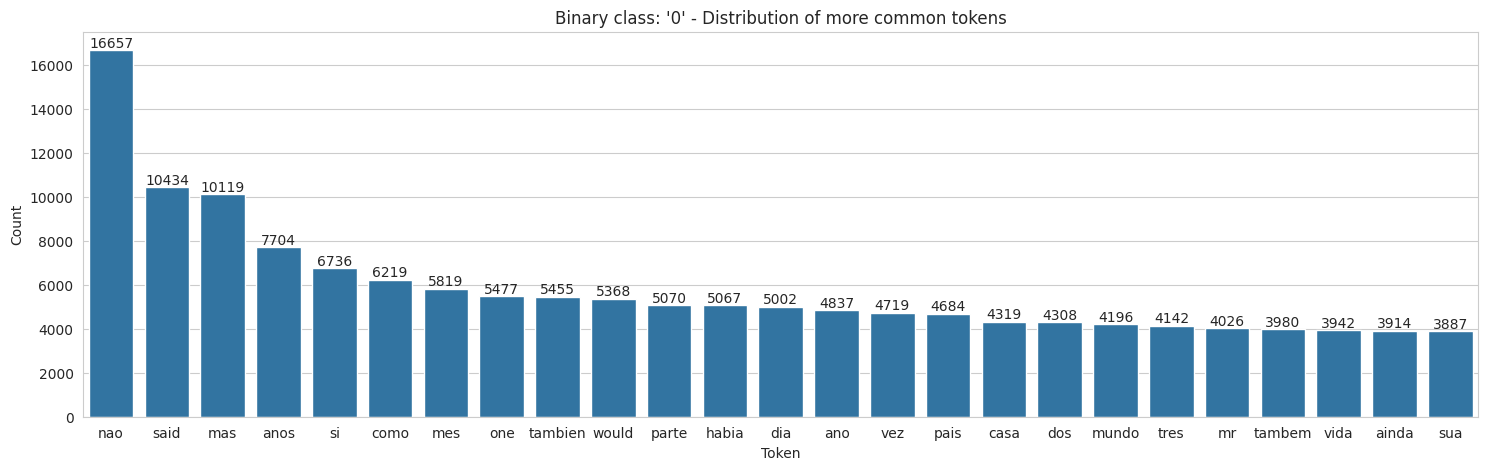

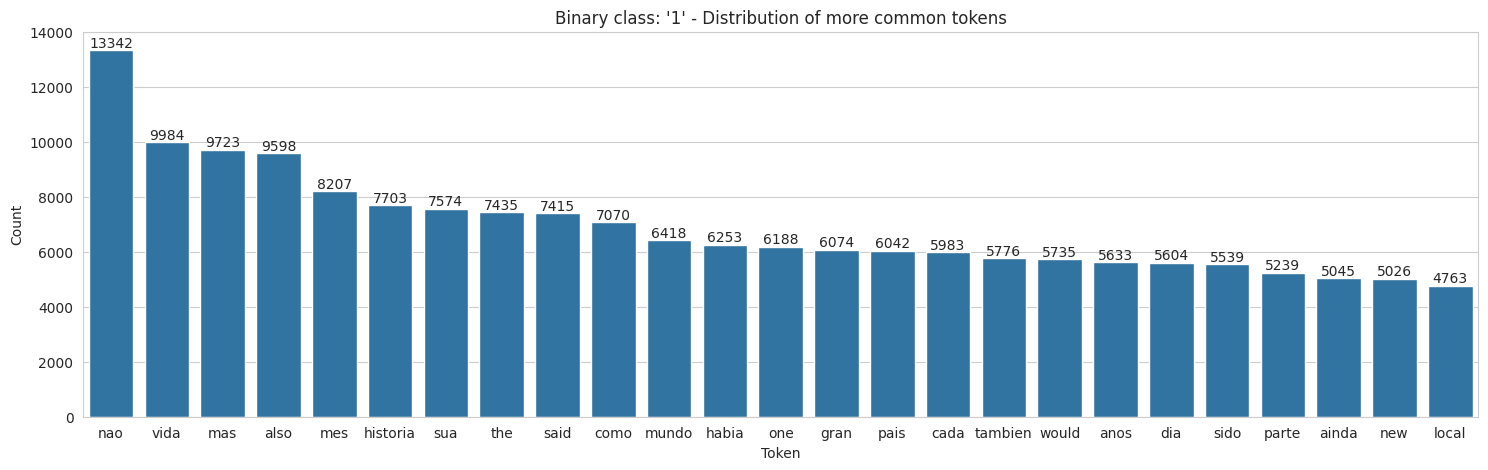

In [61]:
top_more_popular_tokens: int = 25
train_set_more_pop_tokens_by_class: dict[str, pd.DataFrame] = get_more_common_tokens_by_class(df=train_df,
                                                                                              text_column_name="text_v1",
                                                                                              label_column_name="label",
                                                                                              top_more_popular_tokens=top_more_popular_tokens)
for class_label in list(train_set_more_pop_tokens_by_class.keys()):
    draw_barplot(x=train_set_more_pop_tokens_by_class[class_label]["token"],
                 y=train_set_more_pop_tokens_by_class[class_label]["count"],
                 figsize=(18, 5), x_label="Token",
                 title=f"Binary class: '{class_label}' - Distribution of more common tokens")

In [62]:
# Compute overlap between more common tokens for hate and no_hate
more_pop_tokens_human: set[str] = set(train_set_more_pop_tokens_by_class[0]["token"])
more_pop_tokens_mgt: set[str] = set(train_set_more_pop_tokens_by_class[1]["token"])
intersection_set: set[str] = more_pop_tokens_human.intersection(more_pop_tokens_mgt)

print(
    f"Total different tokens that intersect between 'mgt' and 'human' classes in top {top_more_popular_tokens}: {len(intersection_set)}")
print(
    f"Intersection set between top {top_more_popular_tokens} more popular tokens for 'mgt' and 'human' classes: \n{intersection_set}")
print(
    f"Difference in top {top_more_popular_tokens} more popular tokens between 'mgt' and 'human': \n {more_pop_tokens_mgt.difference(more_pop_tokens_human)}")
print(
    f"Difference in top {top_more_popular_tokens} more popular tokens between 'mgt' and 'human': \n {more_pop_tokens_human.difference(more_pop_tokens_mgt)}")

Total different tokens that intersect between 'mgt' and 'human' classes in top 25: 17
Intersection set between top 25 more popular tokens for 'mgt' and 'human' classes: 
{'vida', 'pais', 'como', 'dia', 'nao', 'tambien', 'mas', 'mundo', 'anos', 'would', 'said', 'mes', 'habia', 'ainda', 'parte', 'one', 'sua'}
Difference in top 25 more popular tokens between 'mgt' and 'human': 
 {'new', 'sido', 'also', 'the', 'cada', 'local', 'historia', 'gran'}
Difference in top 25 more popular tokens between 'mgt' and 'human': 
 {'ano', 'vez', 'si', 'dos', 'tambem', 'casa', 'tres', 'mr'}


Even with this cleanup, most popular words are still the same for both labels. This could make the models' task a bit more complex (particularly for ML-based approaches). However, we've performed some cleanup that in theory should help.

# **Dataset Generation**

In this section, we will generate all the datasets that will be used in the subsequent notebooks and persist them to disk so they can be read directly later. Notice that they can weigh a lot, so I'll try to leave only mandatory columns of the dataset.

A summary table synthesizing all the generated datasets has also been defined. You can see it [here](#index-of-generated-datasets).

The pipeline we can follow to build different versions of the dataset and then train with them is as follows:

1. **Start from the original dataset**, consisting of train and test splits.
2. **Clean the datasets using the defined rules.** The same preprocessing applied to train must also be applied to test. Note that the cleaner may return empty strings, for instance, when all content is removed during cleaning. In such cases, empty samples should be dropped from both the train and test sets after cleaning (or kept in the original form).
3. **Check for duplicate comments within the train and test sets that have different labels.** If found, drop them.
4. **Check for duplicate comments between train and test sets.** If duplicates are found, remove them from the train set to ensure the test set is left as unaltered as possible.
5. **Stratified Split of the train set.** This will give us a train and validation split. We will specify a percentage of the train set to be allocated to validation, e.g., 20%.
6. **Data Augmentation of the train set.** Since for the binary task (MGT Detection) the samples per class are pretty balanced, I will ignore this step.
7. **Keep only mandatory columns** of the dataset, so we save some space.
8. **Train the model** using the train set obtained in `(5)`.
9. **Validate the model** using the validation set obtained in `(5)`.
10. **Test the model** using the test set.

As always, we will build a class to encapsulate this process, making it easier to apply variations later on. For the version used on DL approaches, I've decided to leave the data unaltered.

In [65]:
@dataclass
class DatasetPipelineConfig:
    cleaner: TextCleaner
    """ Cleaner to use in the pipeline """
    validation_split: float = 0.15
    """ Percentage of the train set that we want to use for validation of the model. """
    content_field: str = "text"
    """ The column in the dataframe that contains the text"""
    label_field: str = "label"
    """ The column in the dataframe that contains the binary label"""
    language_field: str = "language"
    """ The column of the dataframe that contains the language information"""
    columns_to_keep: list[str] = field(default_factory=lambda: ["id", "prompt", "text", "label"])
    """ Columns in the dataframe to keep """


class DatasetPipeline:
    def __init__(self, config: DatasetPipelineConfig):
        """
        Initialize the DatasetPipeline with a cleaner, and validation split percentage.
        
        Parameters:
        config: the configuration needed to build the dataset
        """
        self._config: DatasetPipelineConfig = config

    def process(self, train_df: pd.DataFrame, test_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Process the datasets through the pipeline.
        
        Parameters:
        train_df: pd.DataFrame, the loaded dataframe for training
        test_df: pd.DataFrame, the loaded dataframe for testing
        
        Returns:
        A tuple that contains the train, validation and test datasets to use
        """
        comment_field: str = self._config.content_field
        language_field: str = self._config.language_field
        # Step 1: Load the datasets
        orig_train_df: pd.DataFrame = train_df
        orig_test_df: pd.DataFrame = test_df

        print(f"Total original train samples: {len(orig_train_df)}")
        print(f"Total original test samples: {len(orig_test_df)}")
        perc_test: float = round((len(orig_test_df) / (len(orig_train_df) + len(orig_test_df))) * 100, 3)
        print(f"Total original percentage of test samples: {perc_test}% \n")

        # Step 2: Clean the datasets with the cleaner object
        print("Cleaning dataframes...")
        cleaner: TextCleaner = self._config.cleaner
        train_df: pd.DataFrame = orig_train_df.copy()
        test_df: pd.DataFrame = orig_test_df.copy()
        train_df[comment_field] = orig_train_df.apply(lambda r: cleaner.clean(r[comment_field], r[language_field]),
                                                      axis=1)
        test_df[comment_field] = orig_test_df.apply(lambda r: cleaner.clean(r[comment_field], r[language_field]),
                                                    axis=1)

        train_df = train_df.dropna(subset=[comment_field])
        train_df = train_df[train_df[comment_field] != '']
        test_df = test_df.dropna(subset=[comment_field])
        test_df = test_df[test_df[comment_field] != '']
        print(f"Total train samples after cleanup: {len(train_df)}")
        print(f"Total test samples after cleanup: {len(test_df)}")
        print("Cleaning done! \n")

        # Step 3: Validate and resolve duplicate comments with different labels within train and test
        print("Duplicates analysis...")
        print("Train duplicates ===")
        train_df = self._resolve_duplicates_within_set(df=train_df)
        print("Test duplicates ===")
        test_df = self._resolve_duplicates_within_set(df=test_df, train=False)

        # Step 4: Validate and remove duplicate comments between train and test
        print("Train/Test cross duplicates ===")
        train_df = self._remove_duplicates_between_sets(train_df, test_df)
        print("Duplicate analysis done! \n")

        # Step 5: Stratified split of train set to get train and validation sets
        print("Performing split...")
        train_df, val_df = self._stratified_split(train_df=train_df)
        val_df: pd.DataFrame
        print("Stratified split done! \n")

        print(f"Final number of elements in train set: {len(train_df)}")
        print(f"Final number of elements in val set: {len(val_df)}")
        print(f"Final number of elements in test set: {len(test_df)}")

        # Return the processed datasets for further use
        columns: list[str] = self._config.columns_to_keep
        return train_df[columns], val_df[columns], test_df[columns]

    def _resolve_duplicates_within_set(self, df: pd.DataFrame, train: bool = True) -> pd.DataFrame:
        """
        Resolve duplicate comments with different labels within a dataset.
        
        Parameters:
        df: DataFrame, the dataset to process.
        
        Returns:
        DataFrame, the dataset with duplicates resolved.
        """
        comment_field: str = self._config.content_field
        label_field: str = self._config.label_field
        set_name: str = "train" if train else "test"

        dups_df: pd.DataFrame = detect_column_duplicates(df=df, column_name=comment_field, set=set_name)
        for _idx, row in dups_df.iterrows():
            comment: str = row[comment_field]
            majority_class: str = Counter(row["labels"]).most_common(1)[0][0]
            # Overwrite the annotations for this label with the majority so whe dropping we don't lose anything!
            df.loc[df[comment_field] == comment, label_field] = majority_class

        dedup_df: pd.DataFrame = df.drop_duplicates(subset=[comment_field], inplace=False)
        dedup_df_dups: pd.DataFrame = detect_column_duplicates(df=dedup_df, column_name=comment_field, set=set_name)
        assert len(dedup_df_dups) == 0, f"There should be no duplicated comments in the dedup dataset!"
        return dedup_df

    def _remove_duplicates_between_sets(self, df_a: pd.DataFrame, df_b: pd.DataFrame) -> pd.DataFrame:
        """
        Remove duplicate comments between two given dataframes
        If there are comments duplicated between both, we delete them from the df_a
        
        Parameters:
        df_a: DataFrame
        df_b: DataFrame
        
        Returns:
        DataFrame, the df_a dataset with duplicates removed.
        """
        comment_field: str = self._config.content_field
        all_df_b_comments: set[str] = set(df_b[comment_field])
        test_comments_in_df_a: int = len(df_a[df_a[comment_field].isin(all_df_b_comments)])
        print(
            f"Total comments in df_b that also appear in df_a: {test_comments_in_df_a}. Deleting them from df_a!")
        train_df = df_a[~df_a[comment_field].isin(all_df_b_comments)]
        return train_df

    def _stratified_split(self, train_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Perform a stratified split of the dataset into train and validation sets.
        
        Parameters:
        train_df: DataFrame, the train dataset to split, after deduping.
        
        Returns:
        train: DataFrame, the training set.
        val: DataFrame, the validation set.
        """
        label_field: str = self._config.label_field
        val_split: float = self._config.validation_split

        # test size has to be recomputed, as the deduping might have changed numbers a bit
        val_size: int = int((len(train_df)) * val_split)
        split_train_df, split_val_df = train_test_split(train_df,
                                                        test_size=val_size,
                                                        stratify=train_df[label_field],
                                                        shuffle=True)
        split_train_df: pd.DataFrame
        split_val_df: pd.DataFrame

        print(f"Total elements in train set after split: {len(split_train_df)}")
        print(f"Total elements in validation set after split: {len(split_val_df)}")

        return cast(tuple[pd.DataFrame, pd.DataFrame], (split_train_df, split_val_df))

## Dataset v1

Relatively light clean up for ML-based models.

I will gzip the output and only print certain columns in order to save some space.

In [84]:
dataset_name: str = "v1"
dataset_folder: str = os.path.join(route_resolver.get_exp_output_notebook_folder(1), dataset_name)
create_dir_if_not_exists(dataset_folder)

cleaner: TextCleaner = TextCleaner(CleaningConfig(
    keep_letters_only=False,
    remove_digits=False,
    remove_punctuation=True,
    normalize_casing=True,
    normalize_unicode_string=True,
    remove_urls=True,
    remove_stopwords=True,
    remove_unicode_symbols=False,
    replace_diacritics=False,
    apply_lemmatization=False,
    apply_stemming=False,
    stopwords=STOPWORDS
))
pipe_config: DatasetPipelineConfig = DatasetPipelineConfig(
    cleaner=cleaner,
    validation_split=0.2,
    columns_to_keep=["id", "text", "label"]
)
pipeline: DatasetPipeline = DatasetPipeline(pipe_config)

# Force reload of dataset to avoid errors for previous operations
train_df, test_df = load_mgt_detection_dataset_as_dataframe()
train_df, val_df, test_df = pipeline.process(
    train_df=train_df,
    test_df=test_df)

# Dump datasets into the OS
print("Persisting datasets...")
train_df.to_csv(path_or_buf=os.path.join(dataset_folder, "train.tsv.gzip"), sep="\t", compression="gzip", index=False)
val_df.to_csv(path_or_buf=os.path.join(dataset_folder, "val.tsv.gzip"), sep="\t", compression="gzip", index=False)
test_df.to_csv(path_or_buf=os.path.join(dataset_folder, "test.tsv.gzip"), sep="\t", compression="gzip", index=False)
print(f"Persisted to: {dataset_folder}")

Total original train samples: 109663
Total original test samples: 43365
Total original percentage of test samples: 28.338% 

Cleaning dataframes...
Total train samples after cleanup: 109662
Total test samples after cleanup: 43365
Cleaning done! 

Duplicates analysis...
Train duplicates ===
Total unique 'text' with the same content for train set: 267
Total 'text' with the same content for train set: 538
Total unique 'text' with the same content for train set: 0
Total 'text' with the same content for train set: 0
Test duplicates ===
Total unique 'text' with the same content for test set: 69
Total 'text' with the same content for test set: 144
Total unique 'text' with the same content for test set: 0
Total 'text' with the same content for test set: 0
Train/Test cross duplicates ===
Total comments in df_b that also appear in df_a: 0. Deleting them from df_a!
Duplicate analysis done! 

Performing split...
Total elements in train set after split: 87513
Total elements in validation set after 

Let's plot the resulting distribution after applying the pipeline.

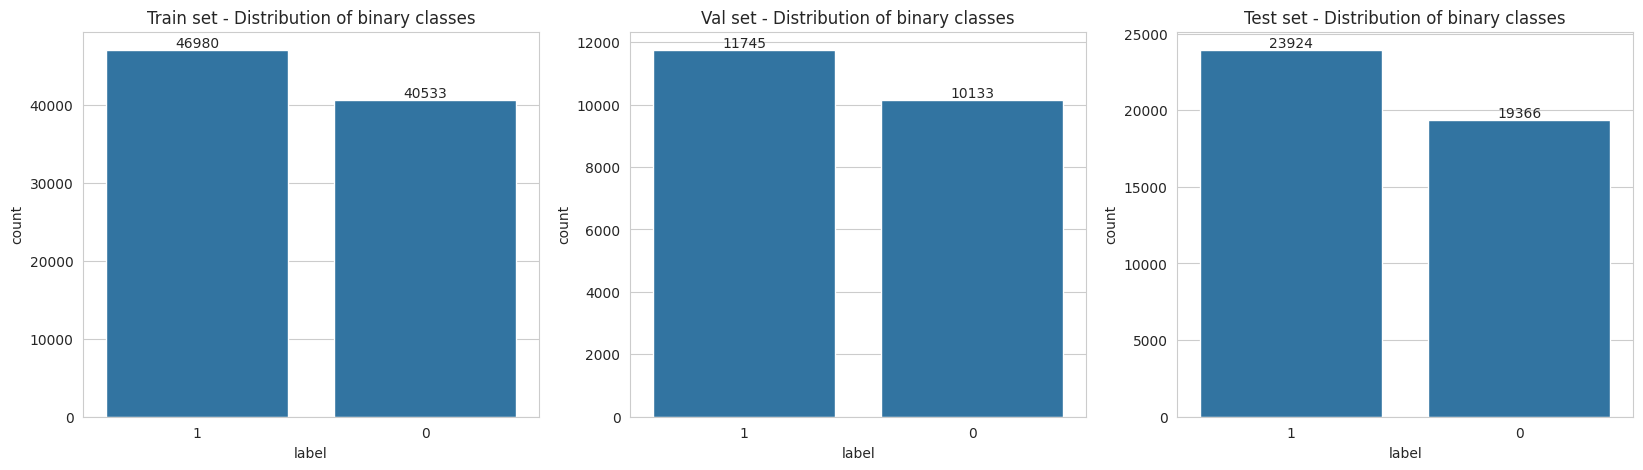

In [85]:
# Briefly check binary label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Train set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Val set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Test set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

plt.show()

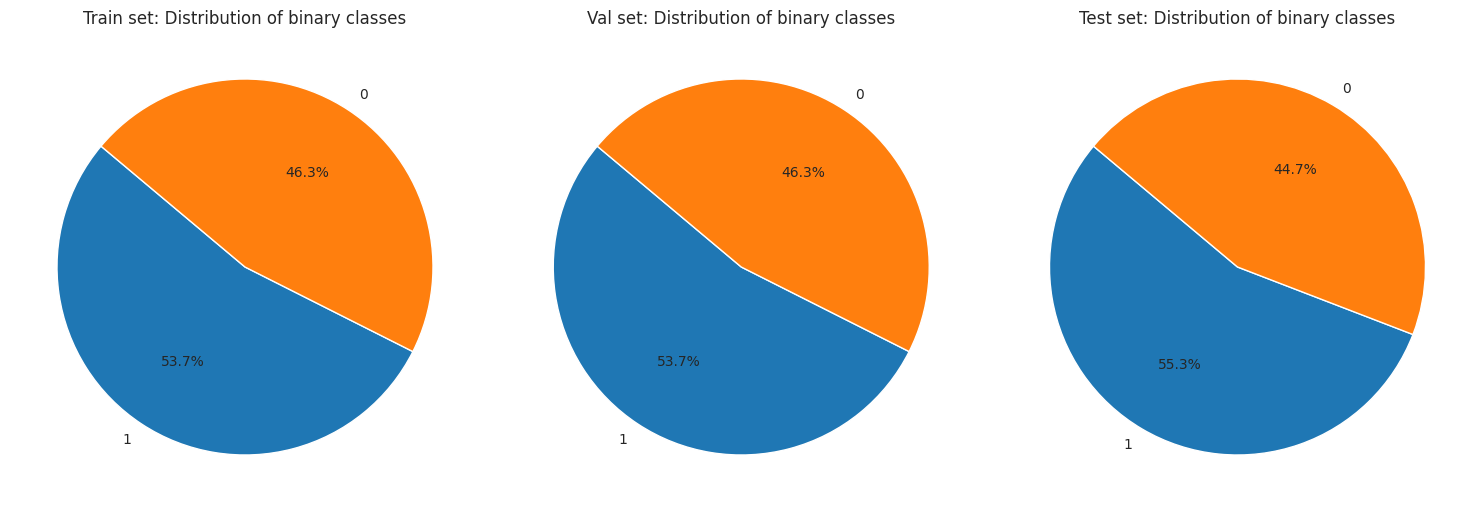

In [86]:
plot_multiple_charts(
    [
        lambda ax: ax.pie(train_df["label"].value_counts(),
                          labels=train_df["label"].value_counts().index,
                          autopct='%1.1f%%', startangle=140),
        lambda ax: ax.pie(val_df["label"].value_counts(),
                          labels=val_df["label"].value_counts().index,
                          autopct='%1.1f%%', startangle=140),
        lambda ax: ax.pie(test_df["label"].value_counts(),
                          labels=test_df["label"].value_counts().index,
                          autopct='%1.1f%%', startangle=140)
    ],
    titles=[
        "Train set: Distribution of binary classes",
        "Val set: Distribution of binary classes",
        "Test set: Distribution of binary classes",
    ],
    n_cols=4,
    figsize=(20, 5)
)

With these charts, we can make sure that we still maintain relatively balanced datasets for binary classes. We can use this to train and evaluate our ML models.

## Dataset V2

This is the dataset for DL-based approaches. I will only apply whitespace normalization and unicode normalization and that's it.

I could also remove "urls", but maybe there is some sort of pattern associated to the generation of the URLs that can help distinguish machine generated texts from human texts, so I'll decide to keep them.

It could've been a great idea to maintain the `prompt` field, so that if we fine-tuned in a contrastive manner, we could sample similar prompts but written by `human` and `mgt` and provide these to the model for fine-tuning, so it could learn to distinguish better how a human and a machine would answer a similar question. Sadly, there's no `prompt` for the `human` generated answers.
We could still do something similar at the text level, to group by semantically similar texts but use as triplets those generated by humans and machines, so that the model can learn how to better differentiate them.

💡 Notice that for this dataset, I will use a smaller validation split, so that the model can benefit from extra data. Using a 10% for validation still gives me a decent number of samples.

In [27]:
dataset_name: str = "v2"
dataset_folder: str = os.path.join(route_resolver.get_exp_output_notebook_folder(1), dataset_name)
create_dir_if_not_exists(dataset_folder)

# I'm putting all cleaner fields so they're easy to change later!
cleaner: TextCleaner = TextCleaner(CleaningConfig(
    keep_letters_only=False,
    remove_digits=False,
    remove_punctuation=False,  # I want to keep this contextual information
    normalize_casing=False,  # I want to keep casing, as it's informative
    normalize_unicode_string=True,
    remove_urls=False,  # URLS probably not relevant, we can get rid of them
    remove_stopwords=False,  # I want to keep stopwords, as they add contextual info
    remove_unicode_symbols=False,  # keep emojis and things like this, they might be relevant for the model
    replace_diacritics=False,
    apply_lemmatization=False,
    apply_stemming=False,
    stopwords=None
))
pipe_config: DatasetPipelineConfig = DatasetPipelineConfig(
    cleaner=cleaner,
    validation_split=0.1,
    columns_to_keep=["id", "text", "label"]
)
pipeline: DatasetPipeline = DatasetPipeline(pipe_config)

# Force reload of dataset to avoid errors for previous operations
train_df, test_df = load_mgt_detection_dataset_as_dataframe()
train_df, val_df, test_df = pipeline.process(
    train_df=train_df,
    test_df=test_df)

# Dump datasets into the OS
print("Persisting datasets...")
train_df.to_csv(path_or_buf=os.path.join(dataset_folder, "train.tsv.gzip"), sep="\t", compression="gzip", index=False)
val_df.to_csv(path_or_buf=os.path.join(dataset_folder, "val.tsv.gzip"), sep="\t", compression="gzip", index=False)
test_df.to_csv(path_or_buf=os.path.join(dataset_folder, "test.tsv.gzip"), sep="\t", compression="gzip", index=False)
print(f"Persisted to: {dataset_folder}")

Total original train samples: 109663
Total original test samples: 43365
Total original percentage of test samples: 28.338% 

Cleaning dataframes...
Total train samples after cleanup: 109663
Total test samples after cleanup: 43365
Cleaning done! 

Duplicates analysis...
Train duplicates ===
Total unique 'text' with the same content for train set: 0
Total 'text' with the same content for train set: 0
Total unique 'text' with the same content for train set: 0
Total 'text' with the same content for train set: 0
Test duplicates ===
Total unique 'text' with the same content for test set: 0
Total 'text' with the same content for test set: 0
Total unique 'text' with the same content for test set: 0
Total 'text' with the same content for test set: 0
Train/Test cross duplicates ===
Total comments in df_b that also appear in df_a: 0. Deleting them from df_a!
Duplicate analysis done! 

Performing split...
Total elements in train set after split: 98697
Total elements in validation set after split: 

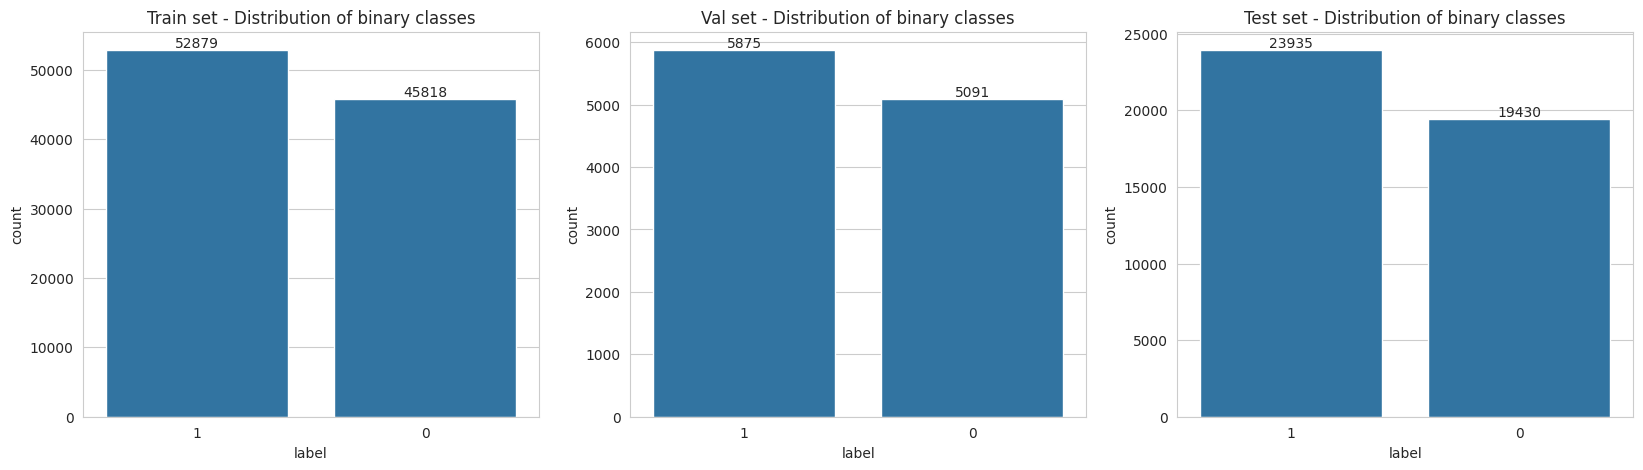

In [28]:
# Briefly check binary label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Train set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Val set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Test set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

plt.show()

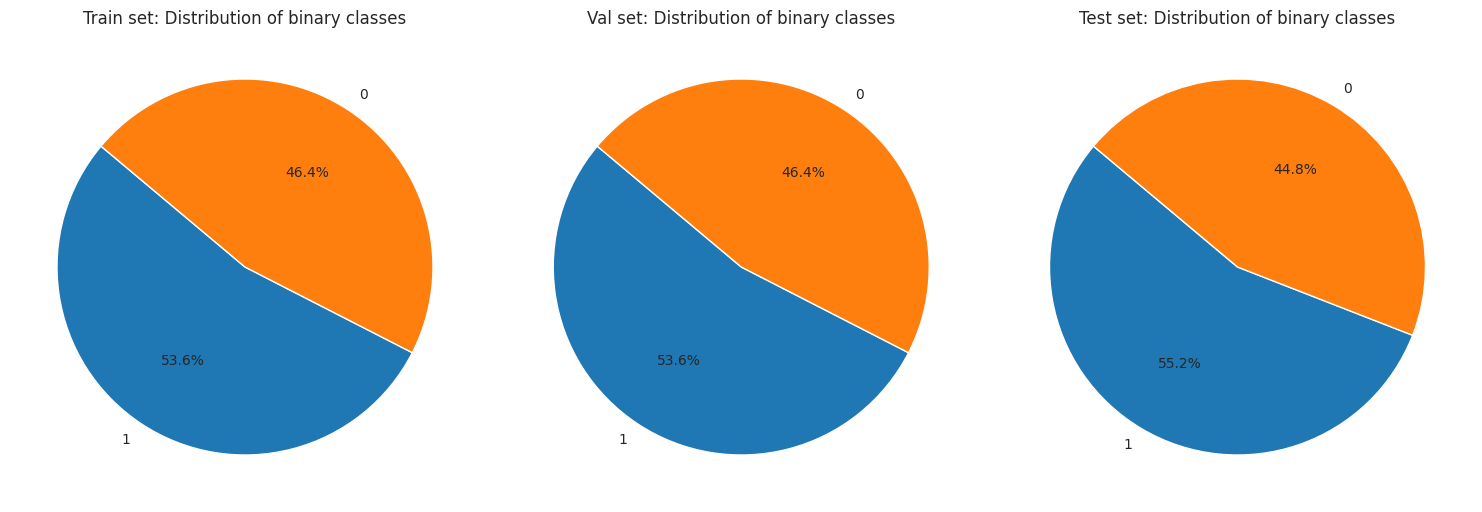

In [29]:
plot_multiple_charts(
    [
        lambda ax: ax.pie(train_df["label"].value_counts(),
                          labels=train_df["label"].value_counts().index,
                          autopct='%1.1f%%', startangle=140),
        lambda ax: ax.pie(val_df["label"].value_counts(),
                          labels=val_df["label"].value_counts().index,
                          autopct='%1.1f%%', startangle=140),
        lambda ax: ax.pie(test_df["label"].value_counts(),
                          labels=test_df["label"].value_counts().index,
                          autopct='%1.1f%%', startangle=140)
    ],
    titles=[
        "Train set: Distribution of binary classes",
        "Val set: Distribution of binary classes",
        "Test set: Distribution of binary classes",
    ],
    n_cols=4,
    figsize=(20, 5)
)

We have our `v2` ready to be used.

## Dataset V3

I came back to this flow again after trying multiple attempts to fine-tune our SetFit models with the whole `v2` dataset in `3_dl_approaches`.
In this opportunity, I'm going to sample a set of 60k elements from training (as this is the maximum number of elements I could fit into memory) by doing some smart selection of samples.

Notice that I will also apply no cleanup whatsoever to the data, so I can use the results obtained here as potential results for the competition.

My goal will be to try to make sure that I sample in a way so that multiple conditions are met:
 - Equal representation of both `human` and `machine` classes.
 - For each class, make sure that languages and domains are also equally represented (whenever possible).

In [21]:
# Since this procedure is a bit custom, I will not use `DatasetPipeline` code implemented before
train_df, test_df = load_mgt_detection_dataset_as_dataframe()

train_df.head()

,id,prompt,text,label,domain,language,model
0,15442,Write a wikipedia article using the following ...,Es un tribunal de suprema instanza que forma p...,1,wikipedia,ca,cohere.command-text-v14
1,26409,NO-PROMPT,Aixó de tindrer la platgeta tant prou era un p...,0,reviews,ca,human
2,12777,Write a wikipedia article using the following ...,Doug mcadam es un científico estadista estadou...,1,wikipedia,es,cohere.command-text-v14
3,63467,Write a news article using the following summa...,"El president de la generalitat, carles puigdem...",1,news,ca,gpt-3.5-turbo-instruct
4,41050,Escribe un capítulo de libro que empieza por l...,"Traídas de francia, tan estrafalarias que una ...",1,literary,es,ai21.j2-ultra-v1


In [36]:
# Helper function to sample with stratification, prioritizing languages as specified
def sample_with_strat(source_df, total_size, language_priority: list[str], already_sampled_texts=None):
    if already_sampled_texts is None:
        already_sampled_texts = set()

    # Remove texts that have already been sampled
    valid_df = source_df[~source_df['text'].isin(already_sampled_texts)].copy()

    strat_groups = valid_df['strat'].unique()
    samples_per_group = total_size // len(strat_groups) if strat_groups.size > 0 else 0
    remainder = total_size % len(strat_groups) if strat_groups.size > 0 else 0

    result_dfs = []
    deficit_tracking = {}  # Track deficits for reporting
    new_sampled_texts = set()

    for group in strat_groups:
        group_df = valid_df[valid_df['strat'] == group]

        # If group has fewer samples than needed, take all and note the deficit
        if len(group_df) <= samples_per_group:
            result_dfs.append(group_df)
            new_sampled_texts.update(group_df['text'].tolist())
            deficit = samples_per_group - len(group_df)

            if deficit > 0:
                deficit_tracking[group] = {'deficit': deficit, 'makeup': {}}

            # Try to make up deficit using the language priority list
            for priority_lang in language_priority:
                if deficit <= 0:
                    break

                # Find groups of the current priority language
                priority_groups = [g for g in strat_groups if g.startswith(f'{priority_lang}_') and g != group]

                # Sort by available samples (descending) to efficiently use them
                priority_groups = sorted(
                    priority_groups,
                    key=lambda g: len(valid_df[valid_df['strat'] == g]),
                    reverse=True
                )

                # Try groups with the current priority language
                for priority_group in priority_groups:
                    if deficit <= 0:
                        break
                    priority_df = valid_df[valid_df['strat'] == priority_group]
                    # Exclude texts already selected in this sampling round
                    priority_df = priority_df[~priority_df['text'].isin(new_sampled_texts)]

                    if len(priority_df) > samples_per_group + 5:  # +5 buffer
                        extra = min(deficit, len(priority_df) - samples_per_group - 5)
                        if extra > 0:
                            extra_samples = priority_df.sample(extra)
                            result_dfs.append(extra_samples)
                            new_sampled_texts.update(extra_samples['text'].tolist())
                            deficit -= extra
                            # Track makeup for reporting
                            lang = priority_group.split('_')[0]
                            if lang in deficit_tracking[group]['makeup']:
                                deficit_tracking[group]['makeup'][lang] += extra
                            else:
                                deficit_tracking[group]['makeup'][lang] = extra

            # If there's still a deficit after trying all priority languages,
            # we need to find samples from any available group
            if deficit > 0:
                other_groups = [g for g in strat_groups if g != group]
                for other_group in other_groups:
                    if deficit <= 0:
                        break
                    other_df = valid_df[valid_df['strat'] == other_group]
                    # Exclude texts already selected in this sampling round
                    other_df = other_df[~other_df['text'].isin(new_sampled_texts)]

                    if len(other_df) > samples_per_group + 5:
                        extra = min(deficit, len(other_df) - samples_per_group - 5)
                        if extra > 0:
                            extra_samples = other_df.sample(extra)
                            result_dfs.append(extra_samples)
                            new_sampled_texts.update(extra_samples['text'].tolist())
                            deficit -= extra
                            # Track makeup for reporting
                            lang = other_group.split('_')[0]
                            if lang in deficit_tracking[group]['makeup']:
                                deficit_tracking[group]['makeup'][lang] += extra
                            else:
                                deficit_tracking[group]['makeup'][lang] = extra
        else:
            # Add extra sample to top groups if there's a remainder
            extra = 1 if remainder > 0 else 0
            if extra > 0:
                remainder -= 1

            # Make sure we don't have duplicate texts in our sample
            available_texts = set(group_df['text']) - new_sampled_texts
            max_available = min(samples_per_group + extra, len(available_texts))
            if max_available > 0:
                sampled_df = group_df[group_df['text'].isin(available_texts)].sample(max_available)
                result_dfs.append(sampled_df)
                new_sampled_texts.update(sampled_df['text'].tolist())

    if result_dfs:
        sampled_df = pd.concat(result_dfs)
        # Double-check no duplicates (should not be needed but safety check)
        sampled_df = sampled_df.drop_duplicates(subset=['text'])
    else:
        # If we couldn't sample anything (extreme case), return empty DataFrame
        sampled_df = pd.DataFrame(columns=valid_df.columns)

    return sampled_df, deficit_tracking, new_sampled_texts


def stratified_sampling(df, train_size=60000, val_size=10000, language_priority=None):
    """
    Perform stratified sampling on the dataset to ensure:
    1. 50% human (label=0) and 50% machine (label=1) samples
    2. Equal distribution across language, domain, and model within each label group
    3. Prioritize languages according to the provided priority list when making up for deficits
    4. No duplicate texts within or between train and validation sets

    Args:
        df: pandas DataFrame with columns [label, text, domain, language, model]
        train_size: number of samples for training set
        val_size: number of samples for validation set
        language_priority: list of languages in priority order (default: ['english', ...])

    Returns:
        train_df: DataFrame with training samples
        val_df: DataFrame with validation samples
    """
    # Default language priority if none provided (English first)
    if language_priority is None:
        language_priority = ['en', 'es', 'pt', 'ca', 'eu', 'gl']

    # First, remove any duplicated texts in the original dataset
    df = df.drop_duplicates(subset=['text']).reset_index(drop=True)

    # Calculate sizes for each label
    human_train_size = train_size // 2
    machine_train_size = train_size // 2
    human_val_size = val_size // 2
    machine_val_size = val_size // 2

    # Split into human and machine dataframes
    human_df = df[df['label'] == 0].copy()
    machine_df = df[df['label'] == 1].copy()

    # Create stratification columns for both dataframes
    human_df['strat'] = human_df['language'] + '_' + human_df['domain'] + '_' + human_df['model']
    machine_df['strat'] = machine_df['language'] + '_' + machine_df['domain'] + '_' + machine_df['model']

    # Keep track of all sampled texts to avoid duplicates between train and validation
    all_sampled_texts = set()

    # Sample data for training human
    human_train, human_deficit_tracking, human_train_texts = sample_with_strat(
        human_df, human_train_size, language_priority, all_sampled_texts
    )
    all_sampled_texts.update(human_train_texts)

    # Sample data for training machine
    machine_train, machine_deficit_tracking, machine_train_texts = sample_with_strat(
        machine_df, machine_train_size, language_priority, all_sampled_texts
    )
    all_sampled_texts.update(machine_train_texts)

    # Sample data for validation human
    human_val, human_val_deficit, human_val_texts = sample_with_strat(
        human_df, human_val_size, language_priority, all_sampled_texts
    )
    all_sampled_texts.update(human_val_texts)

    # Sample data for validation machine
    machine_val, machine_val_deficit, machine_val_texts = sample_with_strat(
        machine_df, machine_val_size, language_priority, all_sampled_texts
    )

    # Combine human and machine datasets
    train_df = pd.concat([human_train, machine_train])
    val_df = pd.concat([human_val, machine_val])

    # Drop stratification column and shuffle results
    train_df = train_df.drop(columns=['strat']).sample(frac=1).reset_index(drop=True)
    val_df = val_df.drop(columns=['strat']).sample(frac=1).reset_index(drop=True)

    deficit_tracking = {
        'human_train': human_deficit_tracking,
        'machine_train': machine_deficit_tracking,
        'human_val': human_val_deficit,
        'machine_val': machine_val_deficit
    }

    # Verify no duplicate texts between train and validation
    train_texts = set(train_df['text'])
    val_texts = set(val_df['text'])
    common_texts = train_texts.intersection(val_texts)

    if common_texts:
        print(f"WARNING: Found {len(common_texts)} duplicate texts between train and validation sets!")
    else:
        print("SUCCESS: No duplicate texts between train and validation sets.")

    # Verify no duplicates within each set
    if len(train_texts) < len(train_df):
        print(f"WARNING: Found {len(train_df) - len(train_texts)} duplicate texts within training set!")
    else:
        print("SUCCESS: No duplicate texts within training set.")

    if len(val_texts) < len(val_df):
        print(f"WARNING: Found {len(val_df) - len(val_texts)} duplicate texts within validation set!")
    else:
        print("SUCCESS: No duplicate texts within validation set.")

    # Return the actual sizes for reporting
    actual_sizes = {
        'requested_train_size': train_size,
        'actual_train_size': len(train_df),
        'requested_val_size': val_size,
        'actual_val_size': len(val_df)
    }

    return train_df, val_df, deficit_tracking, actual_sizes

In [50]:
train_df, test_df = load_mgt_detection_dataset_as_dataframe()
train_df, val_df, _, _ = stratified_sampling(train_df, train_size=60000, val_size=10000)

SUCCESS: No duplicate texts between train and validation sets.
SUCCESS: No duplicate texts within training set.
SUCCESS: No duplicate texts within validation set.


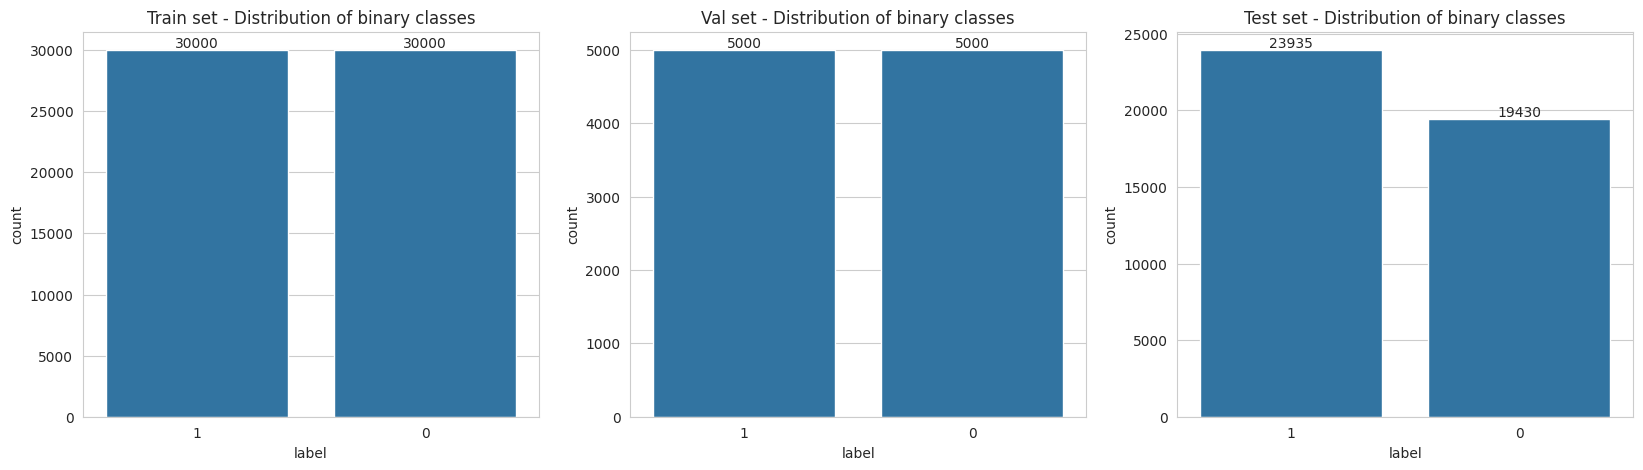

In [51]:
# Briefly check binary label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Train set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Val set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Test set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

plt.show()

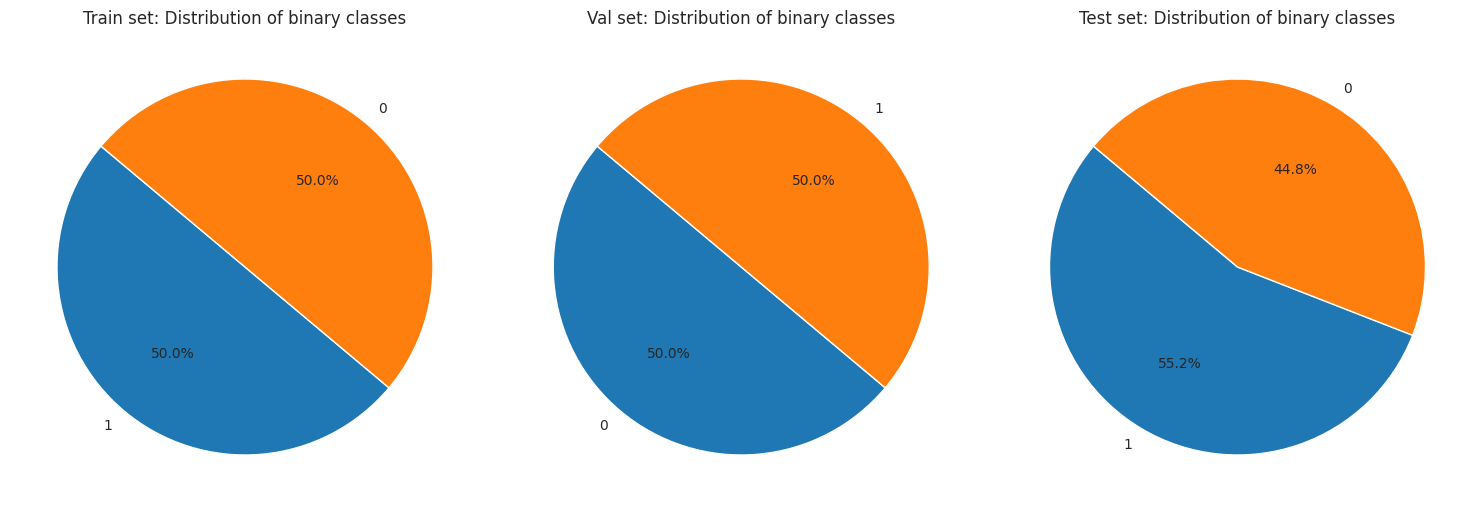

In [52]:
plot_multiple_charts(
    [
        lambda ax: ax.pie(train_df["label"].value_counts(),
                          labels=train_df["label"].value_counts().index,
                          autopct='%1.1f%%', startangle=140),
        lambda ax: ax.pie(val_df["label"].value_counts(),
                          labels=val_df["label"].value_counts().index,
                          autopct='%1.1f%%', startangle=140),
        lambda ax: ax.pie(test_df["label"].value_counts(),
                          labels=test_df["label"].value_counts().index,
                          autopct='%1.1f%%', startangle=140)
    ],
    titles=[
        "Train set: Distribution of binary classes",
        "Val set: Distribution of binary classes",
        "Test set: Distribution of binary classes",
    ],
    n_cols=4,
    figsize=(20, 5)
)

In [53]:
# Make sure that distribution is more or less the same
def _compute_category_id(row) -> str:
    def_category: str = row['language'] + '_' + row['domain']
    return def_category if row["label"] == 0 else f"{def_category}_{row['model']}"


train_df["cat_id"] = train_df.apply(_compute_category_id, axis=1)

In [54]:
train_df.head()[["cat_id"]]

,cat_id
0,es_literary_mistralai/Mixtral-8x7B-Instruct-v0.1
1,eu_news
2,ca_literary_meta-llama/Llama-2-70b-chat-hf
3,en_literary
4,pt_tweets


In [55]:
train_df[train_df["label"] == 0]["cat_id"].value_counts()

cat_id
en_reviews      1984
en_literary     1961
es_reviews      1885
en_news         1853
es_literary     1746
en_wikipedia    1401
es_wikipedia    1395
es_news         1005
gl_wikipedia    1000
eu_literary     1000
pt_literary     1000
ca_news         1000
eu_news         1000
pt_reviews      1000
gl_news         1000
pt_news         1000
ca_tweets       1000
ca_wikipedia    1000
es_tweets       1000
pt_wikipedia    1000
eu_wikipedia    1000
pt_tweets        692
en_tweets        651
eu_reviews       503
ca_literary      497
ca_reviews       458
gl_reviews       451
gl_literary      227
gl_tweets        179
eu_tweets        112
Name: count, dtype: int64

In [56]:
train_df[train_df["label"] == 1]["cat_id"].value_counts()

cat_id
en_literary_meta-llama/Llama-2-70b-chat-hf        758
en_news_meta-llama/Llama-2-70b-chat-hf            443
en_news_gpt-3.5-turbo-instruct                    327
en_wikipedia_gpt-4                                327
en_wikipedia_cohere.command-text-v14              327
                                                 ... 
eu_tweets_mistralai/Mixtral-8x7B-Instruct-v0.1     16
eu_tweets_gpt-4                                     5
pt_tweets_ai21.j2-ultra-v1                          2
eu_tweets_cohere.command-text-v14                   2
eu_tweets_ai21.j2-ultra-v1                          1
Name: count, Length: 178, dtype: int64

Notice that based on the code, data in English is always prioritized when we ran out of samples, following the priority list provided after that.

Let's make sure that there are no duplicate elements between train or validation.

In [57]:
len(train_df)

60000

In [58]:
len(train_df["text"].unique())

60000

In [59]:
len(val_df)

10000

In [60]:
len(val_df["text"].unique())

10000

It looks good now. Let's store this information (the test set I will not store it as no modifications were made), so we can use it in the next flow.

In [61]:
train_df = train_df.drop(columns=['cat_id']).sample(frac=1).reset_index(drop=True)

In [64]:
# Dump datasets into the OS
dataset_name: str = "v3"
dataset_folder: str = os.path.join(route_resolver.get_exp_output_notebook_folder(1), dataset_name)
create_dir_if_not_exists(dataset_folder)

print("Persisting datasets...")
# Take only columns needed
train_df = train_df[["id", "text", "label"]]
val_df = val_df[["id", "text", "label"]]
train_df.to_csv(path_or_buf=os.path.join(dataset_folder, "train.tsv.gzip"), sep="\t", compression="gzip", index=False)
val_df.to_csv(path_or_buf=os.path.join(dataset_folder, "val.tsv.gzip"), sep="\t", compression="gzip", index=False)
print(f"Persisted to: {dataset_folder}")

Persisting datasets...
Persisted to: /tmp/pycharm_project_557/Tema_2/challenge/experiment_output/1_data_exploration/v3


## Dataset V4

Repeat the same procedure done for `v3`, but in this opportunity I will use 90% of the data for training and 10% of the data for validation. I will also use the whole training dataset, to see if I can finally fit it and train with SetFit in the `3_dl_approaches`

My goal will be to try to make sure that I sample in a way so that multiple conditions are met:
 - Equal representation of both `human` and `machine` classes.
 - For each class, make sure that languages and domains are also equally represented (whenever possible).

To make my life simpler, I will use a random split for the full split betwen train and val.

In [10]:
len(train_df)

109663

In [11]:
math.ceil(len(train_df)*0.1)

10967

In [12]:
len(train_df) - math.ceil(len(train_df)*0.1)

98696

In [13]:
def random_split(df, train_size, val_size):
    """
    Randomly split a dataframe into training and validation sets with specified sizes.

    Parameters:
    -----------
    df : pandas.DataFrame
        The original dataframe to split
    train_size : int
        Number of samples for the training set
    val_size : int
        Number of samples for the validation set

    Returns:
    --------
    tuple
        (train_df, val_df) - Training and validation dataframes
    """
    # Remove duplicates from the original dataframe
    df = df.drop_duplicates().reset_index(drop=True)

    # Check if requested sizes are valid
    total_requested = train_size + val_size
    if total_requested > len(df):
        print(f"Warning: Requested {total_requested} samples, but dataset only has {len(df)} unique rows.")
        print(f"Adjusting sizes proportionally.")
        ratio = train_size / total_requested
        train_size = int(len(df) * ratio)
        val_size = len(df) - train_size

    # Randomly shuffle the indices
    indices = np.random.permutation(len(df))

    # Select indices for train and validation
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]

    # Create train and validation dataframes
    train_df = df.iloc[train_indices].reset_index(drop=True)
    val_df = df.iloc[val_indices].reset_index(drop=True)

    # Verify no overlap between sets
    train_texts = set(train_df.text)
    val_texts = set(val_df.text)
    common = train_texts.intersection(val_texts)

    if len(common) == 0:
        print(f"SUCCESS: Split dataset into {len(train_df)} training samples and {len(val_df)} validation samples.")
        print("No duplicates found between training and validation sets.")
    else:
        print(f"WARNING: Found {len(common)} duplicates between training and validation sets!")

    return train_df, val_df

In [14]:
train_df, test_df = load_mgt_detection_dataset_as_dataframe()
train_df, val_df = random_split(train_df, train_size=98696, val_size=10967)

SUCCESS: Split dataset into 98696 training samples and 10967 validation samples.
No duplicates found between training and validation sets.


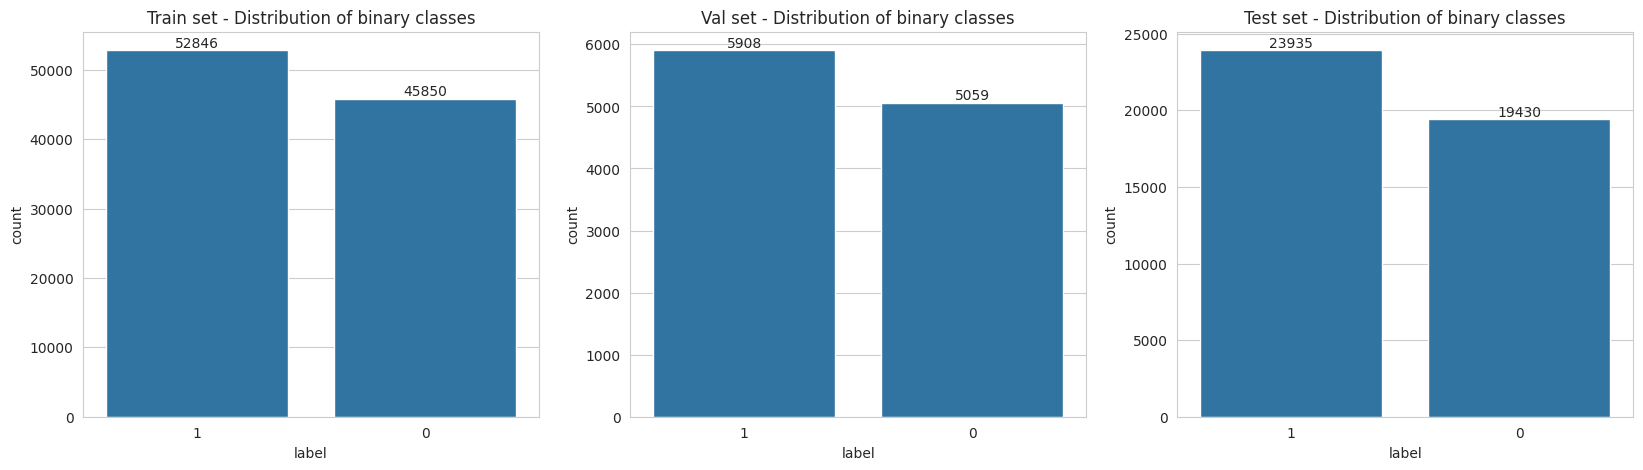

In [15]:
# Briefly check binary label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Train set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Val set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Test set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

plt.show()

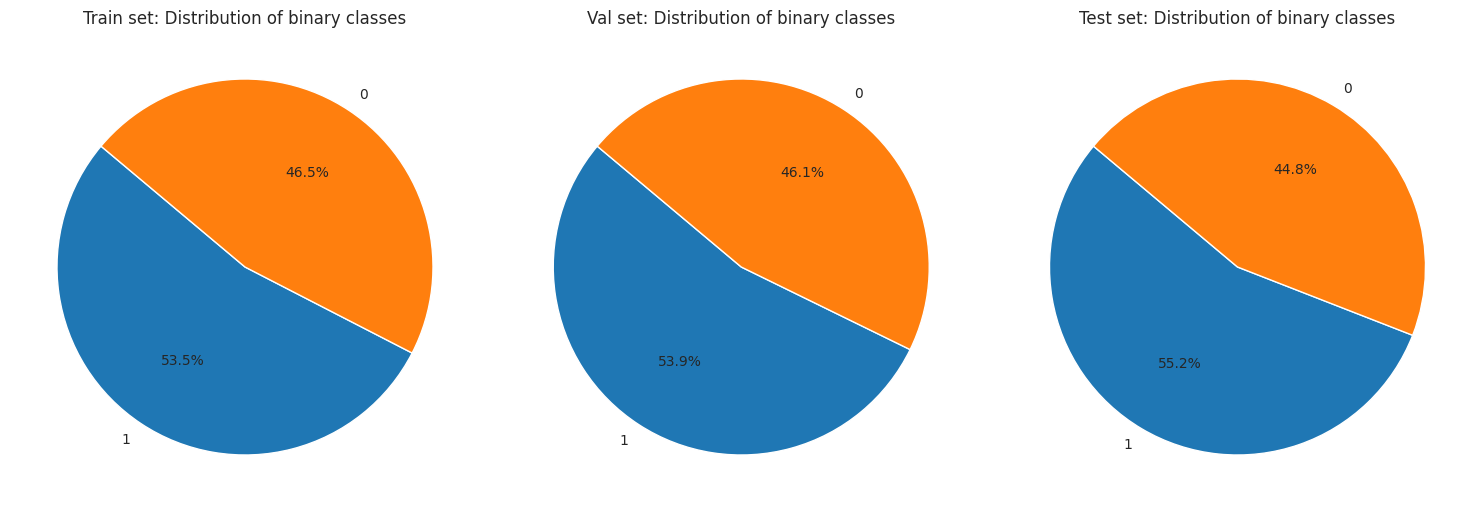

In [16]:
plot_multiple_charts(
    [
        lambda ax: ax.pie(train_df["label"].value_counts(),
                          labels=train_df["label"].value_counts().index,
                          autopct='%1.1f%%', startangle=140),
        lambda ax: ax.pie(val_df["label"].value_counts(),
                          labels=val_df["label"].value_counts().index,
                          autopct='%1.1f%%', startangle=140),
        lambda ax: ax.pie(test_df["label"].value_counts(),
                          labels=test_df["label"].value_counts().index,
                          autopct='%1.1f%%', startangle=140)
    ],
    titles=[
        "Train set: Distribution of binary classes",
        "Val set: Distribution of binary classes",
        "Test set: Distribution of binary classes",
    ],
    n_cols=4,
    figsize=(20, 5)
)

In [17]:
# Dump datasets into the OS
dataset_name: str = "v4"
dataset_folder: str = os.path.join(route_resolver.get_exp_output_notebook_folder(1), dataset_name)
create_dir_if_not_exists(dataset_folder)

print("Persisting datasets...")
# Take only columns needed
train_df = train_df[["id", "text", "label"]]
val_df = val_df[["id", "text", "label"]]
train_df.to_csv(path_or_buf=os.path.join(dataset_folder, "train.tsv.gzip"), sep="\t", compression="gzip", index=False)
val_df.to_csv(path_or_buf=os.path.join(dataset_folder, "val.tsv.gzip"), sep="\t", compression="gzip", index=False)
print(f"Persisted to: {dataset_folder}")

Persisting datasets...
Persisted to: /tmp/pycharm_project_341/Tema_2/challenge/experiment_output/1_data_exploration/v4


# Generated dataset index

| Dataset Name | Description                                            | # train | # val | # test  |
|--------------|--------------------------------------------------------|---------|-------|---------|
| v1           | Cleanup for ML-based models.                           | 87513   | 21878 | 43290   |
| v2           | Super light cleanup for DL-based approaches.           | 98697   | 10966 | 43365   |
| v3           | No cleanup, but sampling of 60k elems for training.    | 60000   | 10000 | 43365   |
| v4           | No cleanup, but sampling randomly between train and val. | 98696   | 10967 | 43365   |


Note that during the generation of the various datasets, we were always careful with the validation and test sets, aiming to maintain the same data proportions and focusing on very light cleanups on the data.

Additionally, we consistently generated validation and test set versions that underwent the same cleanup process as the training set, to ensure that the evaluation is as fair as possible.

On the other hand, we developed a `DatasetPipeline` class, which provides a fairly generic pipeline that we were able to reuse multiple times for generating different versions of the datasets. This pipeline handles aspects such as data cleanup, deduplication, the application of augmentation techniques, and more.

👎 We could spend a lot of time exploring different combinations of cleanup for the data provided. I only implemented two, as I thought are the ones that make the most sense. Notice that no lemmatization or stemming have been applied on the data (this could've made sense if we wanted to use pre-trained embeddings in the next notebook).
